In [2]:
import time
import numpy as np

# Constants

In [18]:
sample_rate = 44100
hop_size = 441 * 2
seq_dur = 10
peak_type = 'gaussian'
width = 4

beatmap_dir = '../beatmaps'
ds_path = './datasets/HN/ds_' + peak_type + '.pkl'
model_path = './models/HN/model08_' + peak_type

# Audio utils

In [3]:
from abc import abstractmethod

In [4]:
class FeatureModule(object):
    
    def __init__(self, sample_rate, hop_length, num_channels=1, decibels=True):
        self.sample_rate = sample_rate
        self.hop_length = hop_length
        self.num_channels = num_channels
        self.decibels = decibels
        
    def get_expected_frames(self, audio):
         # Simply the number of hops plus one
        num_frames = 1 + len(audio) // self.hop_length
        return num_frames
    
    def get_sample_range(self, num_frames):
         # Calculate the boundaries
        max_samples = num_frames * self.hop_length - 1
        min_samples = max(1, max_samples - self.hop_length + 1)

        # Construct an array ranging between the minimum and maximum number of samples
        sample_range = np.arange(min_samples, max_samples + 1)
        return sample_range
    
    @abstractmethod
    def process_audio(self, audio):
        return NotImplementedError
    
    def to_decibels(self, feats):
        feats = librosa.core.amplitude_to_db(feats, ref=np.max)
        return feats

    def post_proc(self, feats):
        if self.decibels:
            # Convert to decibels (dB)
            feats = self.to_decibels(feats)

            # TODO - make additional variable for 0/1 scaling
            # Assuming range of -80 to 0 dB, scale between 0 and 1
            feats = feats / 80
            feats = feats + 1
        else:
            # TODO - should anything be done here? - would I ever not want decibels?
            pass

        # Add a channel dimension
        feats = np.expand_dims(feats, axis=0)
        return feats
    
    def get_times(self, audio):
        num_frames = self.get_expected_frames(audio)

        frame_idcs = np.arange(num_frames + 1)
        # Obtain the time of the first sample of each frame
        times = librosa.frames_to_time(frames=frame_idcs,
                                       sr=self.sample_rate,
                                       hop_length=self.hop_length)
        return times
    
    def get_sample_rate(self):
        sample_rate = self.sample_rate
        return sample_rate

    def get_hop_length(self):
        hop_length = self.hop_length
        return hop_length

    def get_num_channels(self):
        num_channels = self.num_channels
        return num_channels

    @classmethod
    def features_name(cls):
         return cls.__name__

## patch madmom import error with sed

In [8]:
!sed -i 's/from collections import MutableSequence/from collections.abc import MutableSequence/' .env/lib/python3.10/site-packages/madmom/processors.py

In [9]:
from madmom.audio.signal import SignalProcessor, FramedSignalProcessor
from madmom.audio.stft import ShortTimeFourierTransformProcessor
from madmom.audio.spectrogram import (
    FilteredSpectrogramProcessor, LogarithmicSpectrogramProcessor,
    SpectrogramDifferenceProcessor)
from madmom.processors import ParallelProcessor, SequentialProcessor

In [10]:
class LOG_SPECT(FeatureModule):
    def __init__(self, num_channels=1, sample_rate=22050, win_length=2048, hop_size=512, n_bands=[12], mode='online'):
        sig = SignalProcessor(num_channels=num_channels, win_length=win_length, sample_rate=sample_rate)
        self.sample_rate = sample_rate
        self.hop_length = hop_size
        self.num_channels = num_channels
        multi = ParallelProcessor([])
        frame_sizes = [win_length]  
        num_bands = n_bands  
        for frame_size, num_bands in zip(frame_sizes, num_bands):
            if mode == 'online' or mode == 'offline':
                frames = FramedSignalProcessor(frame_size=frame_size, hop_size=hop_size) 
            else:   # for real-time and streaming modes 
                frames = FramedSignalProcessor(frame_size=frame_size, hop_size=hop_size, num_frames=4) 
            stft = ShortTimeFourierTransformProcessor()  # caching FFT window
            filt = FilteredSpectrogramProcessor(
                num_bands=num_bands, fmin=30, fmax=17000, norm_filters=True)
            spec = LogarithmicSpectrogramProcessor(mul=1, add=1)
            diff = SpectrogramDifferenceProcessor(
                diff_ratio=0.5, positive_diffs=True, stack_diffs=np.hstack)
            # process each frame size with spec and diff sequentially
            multi.append(SequentialProcessor((frames, stft, filt, spec, diff)))
        # stack the features and processes everything sequentially
        self.pipe = SequentialProcessor((sig, multi, np.hstack))

    def process_audio(self, audio):
        feats = self.pipe(audio)
        return feats.T

# Beatmap utils

In [11]:
import re
import os
import torch
import math
import scipy.io.wavfile as wav
import subprocess

In [12]:
class Beatmap():    
    
    def __init__(self, beatmap_dir, beatmap, proc, sample_rate=22050, tmp='./wav/', 
                 peak_type='gaussian', hop_size=512, width=4):
        self.beatmap = beatmap
        self.beatmap_dir = beatmap_dir
        self.sample_rate = sample_rate
        self.proc = proc
        self.tmp = tmp
        self.wavf = None
        self.audiof = None
        self.rate = int(sample_rate / hop_size)
        self.w = width
    
        self.timestamp = []
        self.beat_len = []
        self.hitobjects = []
        self.frames = None
        self.beats = None
        self.m = None
        self.hitstream = None
        self.hits = None
        
        peaks = {
            'gaussian': self.create_gaussian_peak, 
            'linear': self.create_linear_peak, 
            'parabolic': self.create_parabolic_peak
        }
        self.create_peak = peaks[peak_type]
        
    def parse_audiof(self):
        with open(os.path.join(self.beatmap_dir, self.beatmap)) as f:
            for l in f:
                if re.match(r'AudioFilename.*', l):
                    self.audiof = re.search('AudioFilename:\s*(.*)', l).group(1)
        
        if not os.path.exists(self.audiof):
            for f in os.listdir(self.beatmap_dir):
                if re.match(self.audiof, f, flags=re.IGNORECASE):
                    self.audiof = f
        
    def get_audiof(self):
        if self.audiof is None:
            self.parse_audiof()
        return self.audiof
        
    def parse_ids(self):
        f = open(os.path.join(self.beatmap_dir, self.beatmap))
        for l in f:
            if re.match(r'BeatmapID.*',  l):
                self.BeatmapID = re.search('BeatmapID:\s*(\d+).*', l).group(1)
            if re.match(r'BeatmapSetID.*', l):
                self.BeatmapSetID = re.search('BeatmapSetID:\s*(\d+).*', l).group(1)
        if 'BeatmapSetID' not in locals():
            self.BeatmapSetID = self.beatmap_dir.split('/')[-1].split(' ')[0]
        if 'BeatmapID' not in locals():
            self.BeatmapID = self.beatmap_dir.split('/')[-1].split(' ')[0]
        f.close()
            
    def parse_wav(self):
        self.parse_ids();
        self.wavf = str(self.BeatmapSetID) + '-' + str(self.BeatmapID) + '.wav'
        
    def create_wav(self):
        self.parse_wav()
        mp3 = os.path.join(self.beatmap_dir, self.get_audiof())
        wav = os.path.join(self.tmp, self.wavf)
        subprocess.call(['ffmpeg', '-hide_banner', '-loglevel', 'error', '-y', 
                         '-i', mp3, '-ar', str(self.sample_rate), wav])
        
    def get_wav(self):
        if self.wavf is None:
            self.parse_wav()
            if not os.path.exists(os.path.join(self.tmp, self.wavf)):
                self.create_wav()
        return self.wavf

    def parse_timings(self):
        rate, audio_data = wav.read(os.path.join(self.tmp, self.get_wav()))
        audio_len = np.shape(audio_data)[0]
        self.beat_len = []
        self.timestamp = []
        
        with open(os.path.join(self.beatmap_dir, self.beatmap)) as f:
            for l in f:
                if re.match(r'BeatDivisor.*', l):
                    self.BeatDivisor = re.search('BeatDivisor:\s*(\d+).*', l).group(1)
                    self.BeatDivisor = int(self.BeatDivisor)
                    break
        f = open(os.path.join(self.beatmap_dir, self.beatmap))
        for l in f:
            if re.match(r'\[TimingPoints\]', l):
                break
        for l in f:
            if l == "\n":
                break
            a = l.split(',')
            if float(a[1]) < 0:
                continue
            self.beat_len.append(float(a[1]))
            self.timestamp.append(float(a[0])) 
        self.timestamp.append(int(audio_len / rate * 1000))
        f.close()
        
    def parse_hitobjects(self):
        self.hitobjects = []
        with open(os.path.join(self.beatmap_dir, self.beatmap)) as f:
            for l in f:
                if re.match(r'ApproachRate.*', l):
                    AR = float(l.split(':')[1])
                    if AR < 5.0:
                        preempt = 1200 + 600 * (5 - AR) / 5
                        fadein = 800 + 400 * (5 - AR) / 5
                    else:
                        preempt = 1200 - 750 * (AR - 5) / 5
                        fadein = 800 - 500 * (AR - 5) / 5
                    self.preempt = preempt - fadein*0.1
                    break
        with open(os.path.join(self.beatmap_dir, self.beatmap)) as f:
            for l in f:
                if re.match(r'SliderMultiplier.*', l):
                    self.sliderMultiplier = float(l.split(':')[1])
                    break
        f = open(os.path.join(self.beatmap_dir, self.beatmap))
        for l in f:
            if re.match(r'\[HitObjects\]', l):
                break
        for l in f:
            self.hitobjects.append(l.split(','))
        f.close()
        
    def parse_beatmap(self):
        self.parse_timings()
        self.parse_hitobjects()
    
    def process_audio(self):
        feats = self.proc.process_audio(os.path.join(self.beatmap_dir, self.get_audiof()))
        feats = torch.tensor(feats)
        self.frames = torch.transpose(feats, 0, 1)
        
    def create_gaussian_peak(self, y, i):
        alen = len(y)
        w = self.w/2/2
        
        def func(x):
            return math.exp(-j**2/w**2)
        
        j = 0 
        while i+j > 0 and abs(j) <= w*2:
            f = func(j)
            y[i+j] = max(y[i+j], f, 0)
            j -= 1
        j = 0
        while i+j < alen and abs(j) <= w*2:
            f = func(j)
            y[i+j] = max(y[i+j], f, 0)
            j += 1
            
    def create_parabolic_peak(self, y, i):
        alen = len(y)
        limit = self.w*2
        w = self.w

        def func(x):
            return -(1/w**2 * x**2) + 1

        j = 0        
        while i+j > 0 and abs(j) <= limit:
            f = func(j)
            y[i+j] = max(y[i+j], f, 0)
            j -= 1
        j = 0
        while i+j < alen and abs(j) <= limit:
            f = func(j)
            y[i+j] = max(y[i+j], f, 0)
            j += 1
            
    def create_linear_peak(self, y, i):
        alen = len(y)
        w = self.w/2
        m = 1/w
        limit = w
        
        def func(x):
            return m*x + 1
        
        j=0
        while i+j > 0 and abs(j) <= limit:
            f = func(j)
            y[i+j] = max(y[i+j], f, 0)
            j -= 1
        m = -m
        j = 0
        while i+j < alen and abs(j) <= limit:
            f = func(j)
            y[i+j] = max(y[i+j], f, 0)
            j += 1  
    
    def process_beats(self):
        if len(self.timestamp) == 0:
            self.parse_beatmap()
        self.beats = np.zeros(math.ceil(self.timestamp[-1] * 0.001 * self.rate), dtype=np.float32)
        
        i = self.timestamp[0] * 0.001 * self.rate
        while i > 0:
            x = round(i)
            self.create_peak(self.beats, x)
            i -= self.beat_len[0] * 0.001 * self.rate
        for j in range(len(self.timestamp) - 1):
            i = self.timestamp[j] * 0.001 * self.rate
            while i < (self.timestamp[j+1] * 0.001 * self.rate):
                x = round(i)
                self.create_peak(self.beats, x)
                i += self.beat_len[j] * 0.001 * self.rate
            if i >= self.timestamp[-1] * 0.001 * self.rate:
                break
                
    def process_hitobjects(self):
        global debug
        if len(self.hitobjects) == 0:
            self.parse_beatmap()
        self.hitstream = [None] * math.ceil(self.timestamp[-1] * 0.001 * self.rate)
        
        sr = 1.0/self.rate * 1000
        time = 0.0
        i = 0
        k = 0
        self.hitstream[k] = []
        while i != len(self.hitobjects):
            if float(self.hitobjects[i][2]) < time:
                i += 1
                continue
            j = i
            while j < len(self.hitobjects):
                if float(self.hitobjects[j][2]) > time + self.preempt or float(self.hitobjects[j][2]) < time:
                    break
                hit_type = int(self.hitobjects[j][3]) & 0b0011
                self.hitstream[k].append(hit_type)
                
                if int(hit_type) & 0b0010 != 0:
                    slider_rate = None
                    length = None
                    for i in range(len(self.timestamp)-1, 0-1, -1):
                        if slider_rate != None:
                            if self.beat_len[i] < 0.0:
                                continue
                            length = self.beat_len[i]
                            break
                        if self.timestamp[i] < float(self.hitobjects[j][2]):
                            if self.beat_len[i] > 0.0:
                                slides = 100
                                slider_rate = self.beat_len[i]
                                break
                            else:
                                slides = self.beat_len[i] * -1
                    if length == None:
                        length = self.beat_len[0]
                        slider_rate = 100
                    length = float(length)
                    y = round(float(self.hitobjects[j][7]) * length / (100/slider_rate * self.sliderMultiplier * 100.0) * 0.001 * self.rate)
                    for i in range(int(self.hitobjects[j][6])):
                        self.hitstream[k].append(-1)
                    
                j += 1
            
            time += sr
            debug = self.hitstream
            k += 1
            self.hitstream[k] = []
    
    def process_hits(self):
        if len(self.hitobjects) == 0:
            self.parse_beatmap()
        self.hits = np.zeros(math.ceil(self.timestamp[-1] * 0.001 * self.rate), dtype=np.float32)
        
        for h in self.hitobjects:
            x = round(float(h[2]) * 0.001 * self.rate)
            self.create_peak(self.hits, x)
            
            if int(h[3]) & 2 == 2:
                slider_rate = None
                length = None
                for i in range(len(self.timestamp)-1, 0-1, -1):
                    if slider_rate != None:
                        if self.beat_len[i] < 0.0:
                            continue
                        length = self.beat_len[i]
                        break
                    if self.timestamp[i] < float(h[2]):
                        if self.beat_len[i] > 0.0:
                            slides = 100
                            slider_rate = self.beat_len[i]
                            break
                        else:
                            slides = self.beat_len[i] * -1
                if length == None:
                    length = self.beat_len[0]
                    slider_rate = 100
                length = float(length)
                y = round(float(h[7]) * length / (100/slider_rate * self.sliderMultiplier * 100.0) * 0.001 * self.rate)
                for i in range(0, int(h[6])*y):
                    if x + i > self.hits.shape[0]:
                        break
                    self.create_peak(self.hits, x+i)
                    
    def get_audio(self):
        if self.frames is None:
            self.process_audio()
        return self.frames
    
    def get_hitobjects(self):
        if self.hitstream is None:
            self.process_hitobjects()
        stream = [None] * len(self.hitstream)
        for i in range(len(self.hitstream)):
            if self.hitstream[i] == [] or self.hitstream[i] == None:
                h = np.array([0])
            else:
                h = np.array(self.hitstream[i], dtype=np.float32)
            stream[i] = torch.tensor(np.pad(h, (0, 64 - h.shape[0])))
        return torch.stack(stream)
    
    def get_hits(self):
        if self.hits is None:
            self.process_hits()
        return torch.tensor(self.hits)
    
    def get_beats(self):
        if self.beats is None:
            self.process_beats()
        return torch.tensor(self.beats)
    
    def get_metadata(self):
        if self.BeatDivisor is None:
            self.parse_beatmap()
        return (self.beatmap, self.rate, self.BeatDivisor)
    
    def get_timings(self):
        if len(self.timestamp) == 0:
            self.parse_beatmap()
        return list(zip(self.timestamp, self.beat_len))

# Dataset

In [13]:
import glob
import copy
import gc
import concurrent.futures
import traceback
import torch
from torch.utils.data import Dataset

In [14]:
class Beatmap_Dataset(Dataset):  
    
    def __init__(self, beatmap_dir, proc, seq_dur=10, sample_rate=22050, hop_size=512, width=4, 
                 peak_type='gaussian', threads=4, threading=True):
        self.beatmap_dir = beatmap_dir
        self.proc = proc
        self.sample_rate = sample_rate
        self.hop_size = hop_size
        self.beatmaps = []
        self.seq_len = int(seq_dur * sample_rate / hop_size)
        self.width = width
        
        if beatmap_dir == None:
            self.a = []
            self.o = []
            self.b = []
            self.h = []
            self.t = []
            self.m = []
            return
        
        j = 0
        for r, dirs, _ in os.walk(beatmap_dir):
            for dir in dirs:
                for root, _, files in os.walk(os.path.join(r, dir)):
                    for f in files:
                        if re.match('.*.osu$', f):
                            self.beatmaps.append(Beatmap(root, f, proc, sample_rate=sample_rate, 
                                                         hop_size=hop_size, width=width, peak_type=peak_type))
                            j += 1
                                            
        self.a = [None] * j
        self.o = [None] * j
        self.b = [None] * j
        self.h = [None] * j
        self.t = [None] * j
        self.m = [None] * j 

        def process(i):
            m = self.beatmaps[i]
            self.beatmaps[i] = None
            try:
                print(str(i) + '/' + str(j-1), m.beatmap)            
                self.a[i] = copy.deepcopy(m.get_audio())
                self.o[i] = copy.deepcopy(m.get_hitobjects())
                self.b[i] = copy.deepcopy(m.get_beats())
                self.h[i] = copy.deepcopy(m.get_hits())
                self.t[i] = copy.deepcopy(m.get_timings())
                self.m[i] = copy.deepcopy(m.get_metadata())
            except Exception as e:
                traceback.print_exc()
                print("pruning:", m.beatmap)     
                self.a[i] = None
                self.o[i] = None
                self.b[i] = None
                self.h[i] = None
                self.t[i] = None
                self.m[i] = None
            del m
            #gc.collect()

        if threading:
            executor = concurrent.futures.ThreadPoolExecutor(threads)
            list(executor.map(process, range(j)))
        else:
            list(map(process, range(j)))
                        
        self.beatmaps = list(filter(None, self.beatmaps))
        self.a = list(filter(lambda x: x != None, self.a))
        self.o = list(filter(lambda x: x != None, self.o))
        self.b = list(filter(lambda x: x != None, self.b))
        self.h = list(filter(lambda x: x != None, self.h))
        self.t = list(filter(None, self.t))
        self.m = list(filter(None, self.m))
        
    def take(self, ds, i, j):
        self.a = ds.a[i:j]
        self.o = ds.o[i:j]
        self.b = ds.b[i:j]
        self.h = ds.h[i:j]
        self.m = ds.m[i:j]
        self.t = ds.t[i:j]
        
    def __len__(self):
        return len(self.a)
    
    def __getitem__(self, i):
        if self.seq_len == 0:
            return None
        j = np.random.randint(0, self.a[i].shape[0] - self.seq_len)
        return self.a[i][j: j+self.seq_len], self.o[i][j: j+self.seq_len], self.b[i][j: j+self.seq_len], self.h[i][j: j+self.seq_len], self.t[i][0], (self.m[i], i, j)
    

# Testing

In [ ]:
# debug
log_spect = LOG_SPECT(sample_rate=44100, hop_size=441*2, n_bands=[24], mode='offline')
s = Beatmap_Dataset('../ex/beatmaps', log_spect, sample_rate=44100, hop_size=441*2, width=2, peak_type='linear', threading=True)

0/241/24 sasakure.UK - Spider Thread Monopoly feat. Hatsune Miku (Mishima Yurara) [HOS' Normal].osu
 sasakure.UK - Spider Thread Monopoly feat. Hatsune Miku (Mishima Yurara) [Milan-'s Hard].osu
2/24 sasakure.UK - Spider Thread Monopoly feat. Hatsune Miku (Mishima Yurara) [RLC's Insane].osu
3/24 sasakure.UK - Spider Thread Monopoly feat. Hatsune Miku (Mishima Yurara) [deetz' Deception].osu
4/24 sasakure.UK - Spider Thread Monopoly feat. Hatsune Miku (Mishima Yurara) [Easy].osu
5/24 sasakure.UK - Spider Thread Monopoly feat. Hatsune Miku (Mishima Yurara) [toybot's Insane].osu
6/24 sasakure.UK - Spider Thread Monopoly feat. Hatsune Miku (Mishima Yurara) [Collab Advanced].osu
7/24 TMABird - Everybody's Circulation (Vncegd) [Very Easy].osu
8/24 TMABird - Everybody's Circulation (Vncegd) [Normal].osu
9/24 TMABird - Everybody's Circulation (Vncegd) [Hard (new)].osu
10/24 TMABird - Everybody's Circulation (Vncegd) [Easy (new)].osu
11/24 TMABird - Everybody's Circulation (Vncegd) [Insane].osu


# Process Data

In [ ]:
start = time.time()

log_spect = LOG_SPECT(sample_rate=sample_rate, hop_size=hop_size, n_bands=[24], mode='offline')
ds = Beatmap_Dataset(beatmap_dir, log_spect, seq_dur=seq_dur, sample_rate=sample_rate, 
                     hop_size=hop_size, peak_type=peak_type, width=width, threads=16, threading=True)

end = time.time()
print(end - start, 'secs')

In [ ]:
start = time.time()

torch.save(ds, ds_path)

end = time.time()
print(end - start, 'secs')

In [ ]:
ds = torch.load(ds_path)

# Model

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as nnF

In [19]:
class HN(nn.Module):
    def __init__(self, dim_in, device):
        super(HN, self).__init__()
        
        self.dim_in = dim_in
        self.dim_out = 1
        self.device = device
        
        # convolution
        K = 5
        P = 1
        S = 1
        # pooling
        p = 0
        k = 2
        s = 2
        
        # temporal
        W = dim_in[1]
        W = int(((W - K + 2*P)/S) + 1)
        K = 3
        temporal_dim = int(((W - K + 2*P)/S) + 1)
        self.temporal_dim = temporal_dim
        
        self.conv_out = self.temporal_dim
        self.lstmX_size = self.conv_out + 64 + 1
        print(self.lstmX_size)
        
        self.convA1 = nn.Conv2d(1, 1, (3, 5), padding=1)
        self.convA2 = nn.Conv2d(1, 1, (3, 3), padding=1)

        self.lstmX1 = nn.LSTM(input_size=self.lstmX_size,
                   hidden_size=self.lstmX_size,
                   num_layers=1,
                   batch_first=True,
                   bidirectional=False) 
        self.linearX1 = nn.Linear(self.lstmX_size, 64)
            
        """    
        self.lstmX2 = nn.LSTM(input_size=128,
                   hidden_size=128,
                   num_layers=1,
                   batch_first=True,
                   bidirectional=False) 
        self.linearX2 = nn.Linear(128, 64)
                                  
        self.lstmX3 = nn.LSTM(input_size=64,
                   hidden_size=64,
                   num_layers=1,
                   batch_first=True,
                   bidirectional=False) 
        self.linearX3 = nn.Linear(64, 32)

        self.lstmX4 = nn.LSTM(input_size=32,
                   hidden_size=32,
                   num_layers=1,
                   batch_first=True,
                   bidirectional=False) 
        self.linearX4 = nn.Linear(32, 16)
        """
                                  
        #self.linear2 = nn.Linear(int(self.lstmX_size/self.lstm_layers), int(self.lstmX_size/self.lstm_layers/2))
        self.linear1 = nn.Linear(64, self.dim_out)

        
    def init_hidden(self, batch_size):
        h = torch.zeros(1, batch_size, self.lstmX_size).to(self.device)
        c = torch.zeros(1, batch_size, self.lstmX_size).to(self.device)
        self.hiddenX1 = (h, c)
        """
        h = torch.zeros(1, batch_size, 128).to(self.device)
        c = torch.zeros(1, batch_size, 128).to(self.device)
        self.hiddenX2 = (h, c)
        
        h = torch.zeros(1, batch_size, 64).to(self.device)
        c = torch.zeros(1, batch_size, 64).to(self.device)
        self.hiddenX3 = (h, c)
                                  
        h = torch.zeros(1, batch_size, 32).to(self.device)
        c = torch.zeros(1, batch_size, 32).to(self.device)
        self.hiddenX4 = (h, c)
        """
        

    def forward(self, a, b, o):
        a = a.unsqueeze(1)
        a = self.convA1(a)
        a = nnF.relu(a)
        a = self.convA2(a)
        a = nnF.relu(a)
        a = a.squeeze(1)
        
        b = b.unsqueeze(2)
        
        x = torch.cat([a, b, o], dim=2)
        
        x, self.hiddenX1 = self.lstmX1(x, self.hiddenX1)
        x = self.linearX1(x)
        x = nnF.relu(x)
        """
        x, self.hiddenX2 = self.lstmX2(x, self.hiddenX2)
        x = self.linearX2(x)
        x = nnF.relu(x)
        x, self.hiddenX3 = self.lstmX3(x, self.hiddenX3)
        x = self.linearX3(x)
        x = nnF.relu(x)      
        x, self.hiddenX4 = self.lstmX4(x, self.hiddenX4)
        x = self.linearX4(x)
        x = nnF.relu(x)
        """
        
        #x = self.linear2(x)
        #x = nnF.relu(x)
        x = self.linear1(x)
        
        return x

# Training

In [20]:
import torch
from torch.utils.data import DataLoader
from torchinfo import summary
from qqdm.notebook import qqdm
import matplotlib.pyplot as plt

In [21]:
epochs = 256
batch_size = 32
init_trunc = 1

In [22]:
dim_in = (int(seq_dur * sample_rate / hop_size), 280)
dim_out = 1 #ds.y[0].shape[0]

In [23]:
device = torch.device('cuda')

In [24]:
epoch_cum = 0
val_hist = []
train_hist = []
model = HN(dim_in=dim_in, device=device)
model.to(device)
model.init_hidden(1)

343


In [25]:
summary(model, input_data=[ds.a[0].unsqueeze(0).to(device), ds.b[0].unsqueeze(0).to(device), ds.o[0].unsqueeze(0).to(device)], col_width=16,
        col_names=["input_size",
                "output_size",
                "num_params",
                "kernel_size",
                "mult_adds",])

NameError: name 'ds' is not defined

In [51]:
train_ds = Beatmap_Dataset(None, None, seq_dur=seq_dur, sample_rate=sample_rate, 
                     hop_size=hop_size, peak_type=peak_type, width=width)
val_ds = Beatmap_Dataset(None, None, seq_dur=seq_dur, sample_rate=sample_rate, 
                     hop_size=hop_size, peak_type=peak_type, width=width)

train_ds.take(ds, 0, int(len(ds) * 0.8))
val_ds.take(ds, int(len(ds) * 0.8), len(ds))

train_ldr = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_ldr = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

In [52]:
criterion = nn.MSELoss()
#criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [53]:
def hit_precentage(pred, gt, thresh):
    c = 0
    n = 0
    for i in range(1, gt.shape[0]-2):
        n += 1 if gt[i] == 1.0 else 0
        #print(gt[i], n)
        if pred[i] > pred[i-1] and pred[i] > pred[i+1] and pred[i] >= thresh:
            c += 1 if gt[i] > 0.0 else 0
    if n == 0:
        return 1
    return c / n

In [54]:
def train():
    global epoch_cum
    global A, O, B, H, P
    global l
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        info = qqdm(train_ldr)
        for a, o, b, h, t, m, in info:
            model.init_hidden(a.shape[0])
            A, O, B, H = a.to(device), o.to(device), b.to(device), h.to(device)

            optimizer.zero_grad()
            P = model(A, B, O)

            for i in range(P.shape[0]):
                l = int(t[1][i] * 0.001 * m[0][1][i] * init_trunc)
                H[i][0:l] = torch.tensor([0] * l)
                P[i][0:l] = torch.tensor([0] * l).unsqueeze(1)


            loss = criterion(P[:,:,0:dim_out], H.unsqueeze(2))
            loss.backward()
            optimizer.step()
      
            train_loss += loss.item()
            info.set_infos({'loss': f'{loss.item():.4f}'})

        model.eval()
        torch.no_grad()
        val_loss = 0
        val_acc05 = 0
        val_acc04 = 0
        for a, o, b, h, t, m, in val_ldr:
            model.init_hidden(a.shape[0])
            A, O, B, H = a.to(device), o.to(device), b.to(device), h.to(device)

            P = model(A, B, O)

            for i in range(P.shape[0]):
                l = int(t[1][i] * 0.001 * m[0][1][i] * init_trunc)
                H[i][0:l] = torch.tensor([0] * l)
                P[i][0:l] = torch.tensor([0] * l).unsqueeze(1)

            loss = criterion(P[:,:,0:dim_out], H.unsqueeze(2))
            acc = 0
            for i in range(P.shape[0]):
                acc += hit_precentage(P[i].cpu().detach().numpy(), h[i], 0.5)
            val_acc05 += acc
            acc = 0
            for i in range(P.shape[0]):
                acc += hit_precentage(P[i].cpu().detach().numpy(), h[i], 0.4)
                #print(acc)
            val_acc04 += acc
            
            val_loss += loss.item()

        train_loss = train_loss/len(train_ldr)    
        val_loss = val_loss/len(val_ldr)
        val_acc05 = val_acc05/len(val_ldr)/batch_size
        val_acc04 = val_acc04/len(val_ldr)/batch_size
        print(epoch+epoch_cum, 'of', epochs+epoch_cum)
        print("TRAIN LOSS:", train_loss)
        print("VAL LOSS:", val_loss)
        print("VAL_ACC05:", val_acc05)
        print("VAL_ACC04:", val_acc04)
        train_hist.append(float(train_loss))
        val_hist.append(float(val_loss))
        
        plt.rcParams["figure.figsize"] = (20,1)
        for i in range(dim_out):
            plt.plot(P[0,:,i].cpu().detach().numpy())
            plt.plot(h[i])
            plt.show()
        
        plt.rcParams["figure.figsize"] = (10, 5)
        plt.plot(train_hist)
        plt.plot(val_hist)
        plt.show()
            
    epoch_cum += epochs

 Iters    Elapsed Time      Speed     loss                                      
 36/36  00:00:05<00:00:00  7.15it/s  0.1519                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

0 of 64
TRAIN LOSS: 0.18506749926341903
VAL LOSS: 0.15482528673277962
VAL_ACC05: 0.16459145028874997
VAL_ACC04: 0.17437711286437177


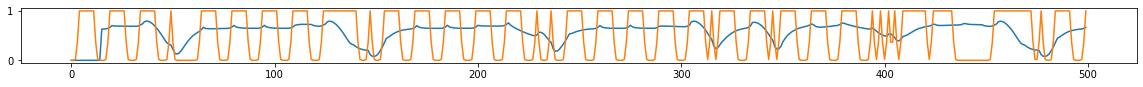

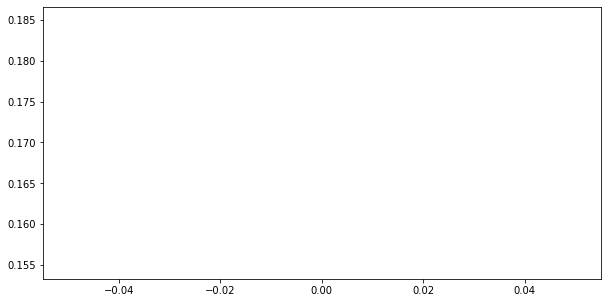

 Iters    Elapsed Time      Speed     loss                                      
 36/36  00:00:05<00:00:00  7.11it/s  0.1380                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

1 of 64
TRAIN LOSS: 0.14163466770615843
VAL LOSS: 0.12984183099534777
VAL_ACC05: 0.16716189124180694
VAL_ACC04: 0.17848215648073357


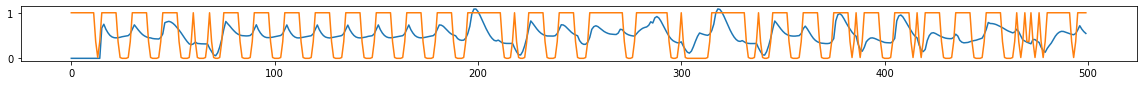

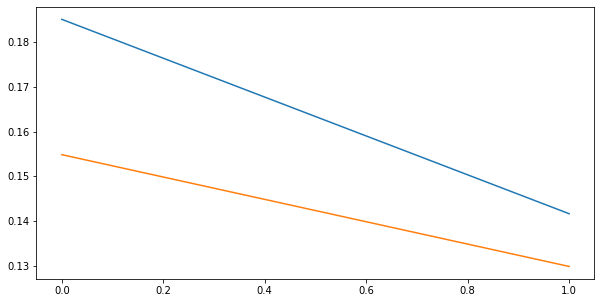

 Iters    Elapsed Time      Speed     loss                                      
 36/36  00:00:05<00:00:00  7.15it/s  0.1009                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

2 of 64
TRAIN LOSS: 0.11707877347038852
VAL LOSS: 0.10877792619996601
VAL_ACC05: 0.17313069621917565
VAL_ACC04: 0.19674771372885042


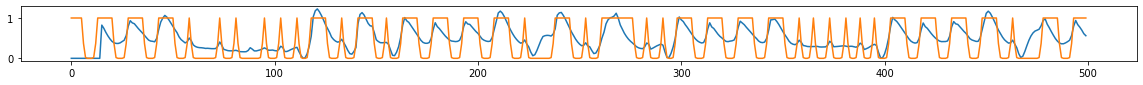

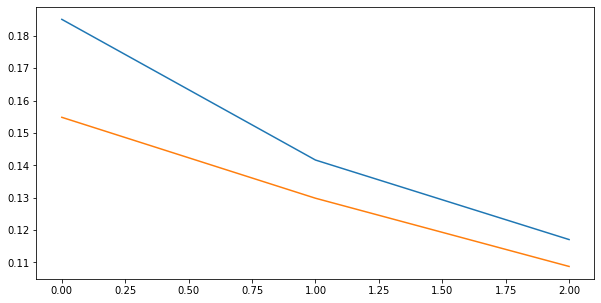

 Iters    Elapsed Time      Speed     loss                                      
 36/36  00:00:05<00:00:00  7.14it/s  0.1057                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

3 of 64
TRAIN LOSS: 0.10271373742984401
VAL LOSS: 0.10080925954712762
VAL_ACC05: 0.20715085031857058
VAL_ACC04: 0.23410760240922102


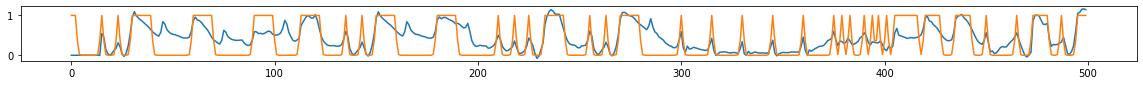

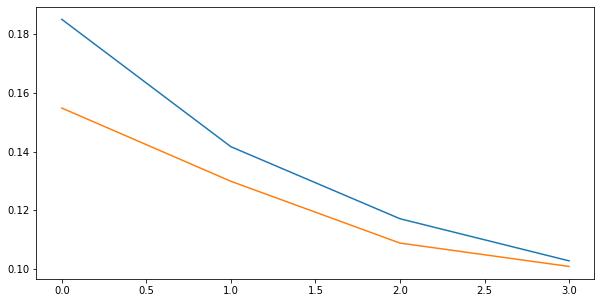

 Iters    Elapsed Time      Speed     loss                                      
 36/36  00:00:05<00:00:00  7.13it/s  0.0949                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

4 of 64
TRAIN LOSS: 0.0951815199934774
VAL LOSS: 0.09195571723911497
VAL_ACC05: 0.29074680258951396
VAL_ACC04: 0.3196946560416418


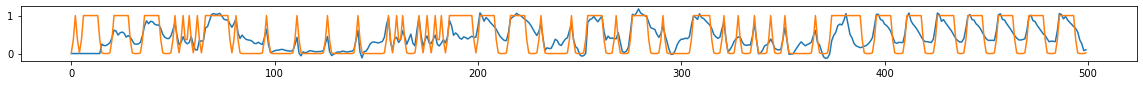

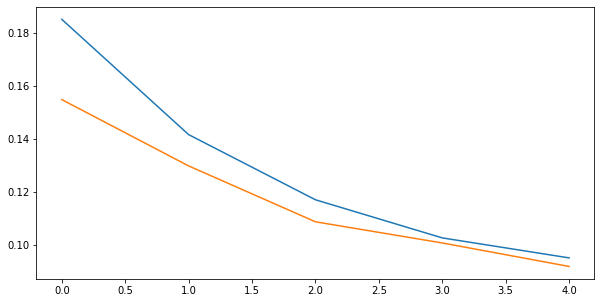

 Iters    Elapsed Time      Speed     loss                                      
 36/36  00:00:05<00:00:00  7.12it/s  0.0780                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

5 of 64
TRAIN LOSS: 0.08674678268531959
VAL LOSS: 0.08795087039470673
VAL_ACC05: 0.2863251679140839
VAL_ACC04: 0.3119714365983378


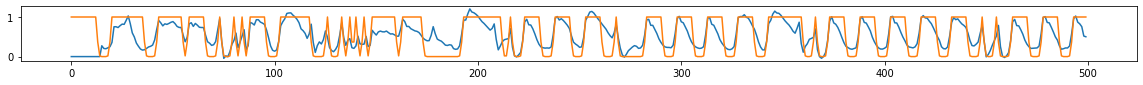

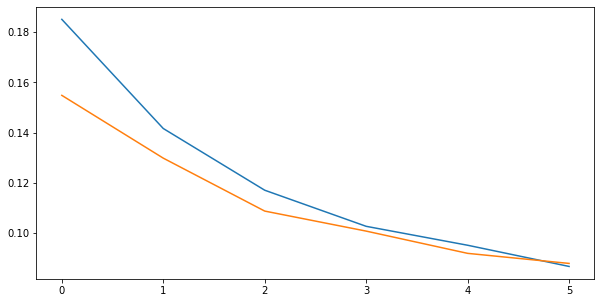

 Iters    Elapsed Time      Speed     loss                                      
 36/36  00:00:05<00:00:00  7.10it/s  0.0786                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

6 of 64
TRAIN LOSS: 0.087043644549946
VAL LOSS: 0.08655681957801183
VAL_ACC05: 0.30269632970215093
VAL_ACC04: 0.32395618487960703


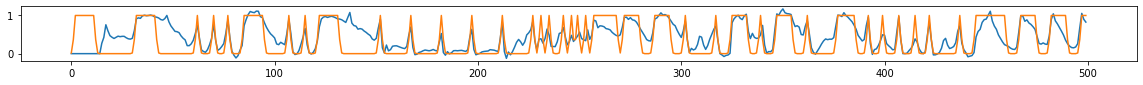

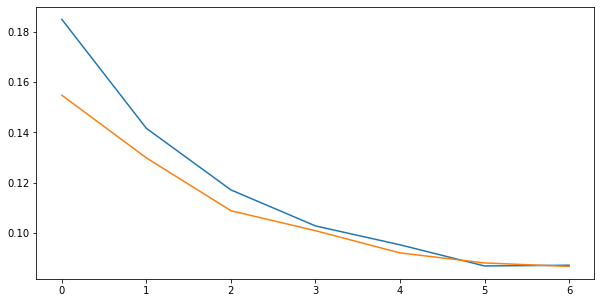

 Iters    Elapsed Time      Speed     loss                                      
 36/36  00:00:05<00:00:00  7.13it/s  0.0941                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

7 of 64
TRAIN LOSS: 0.08406314874688785
VAL LOSS: 0.08211896154615614
VAL_ACC05: 0.29987248135684497
VAL_ACC04: 0.3204443938478121


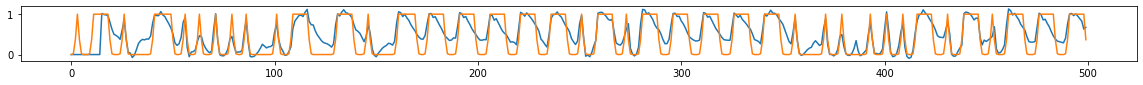

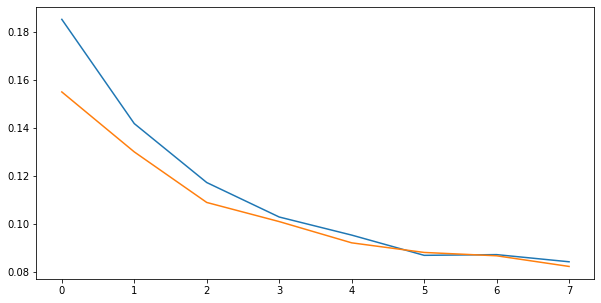

 Iters    Elapsed Time      Speed     loss                                      
 36/36  00:00:05<00:00:00  7.10it/s  0.0804                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

8 of 64
TRAIN LOSS: 0.07991133547491497
VAL LOSS: 0.08655890408489439
VAL_ACC05: 0.2916279713091749
VAL_ACC04: 0.3130158003956015


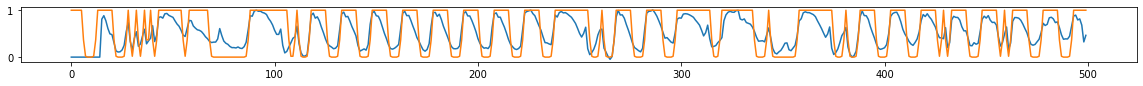

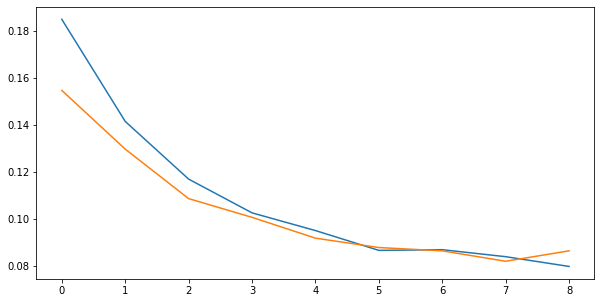

 Iters    Elapsed Time      Speed     loss                                      
 36/36  00:00:05<00:00:00  7.09it/s  0.0718                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

9 of 64
TRAIN LOSS: 0.07591613682193889
VAL LOSS: 0.07777863326999876
VAL_ACC05: 0.30179000877257883
VAL_ACC04: 0.3192391572122445


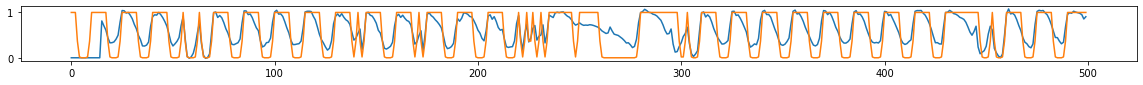

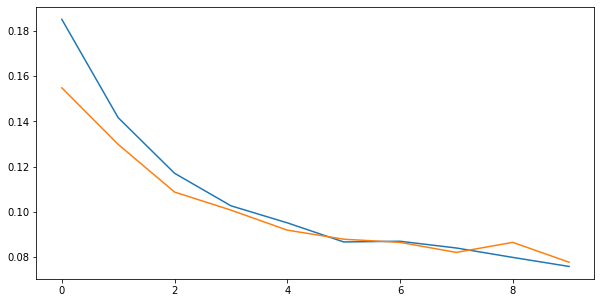

 Iters    Elapsed Time      Speed     loss                                      
 36/36  00:00:05<00:00:00  7.10it/s  0.0786                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

10 of 64
TRAIN LOSS: 0.07670148917370373
VAL LOSS: 0.07728554391198689
VAL_ACC05: 0.299730401051621
VAL_ACC04: 0.3178466504963979


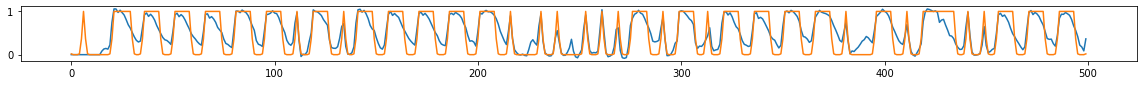

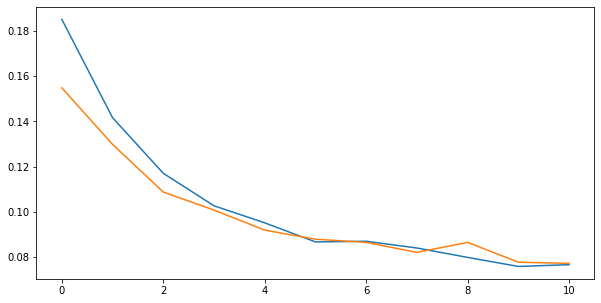

 Iters    Elapsed Time      Speed     loss                                      
 36/36  00:00:05<00:00:00  7.07it/s  0.0738                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

11 of 64
TRAIN LOSS: 0.07375147379934788
VAL LOSS: 0.07899401254124111
VAL_ACC05: 0.28976523997029474
VAL_ACC04: 0.3037508851918298


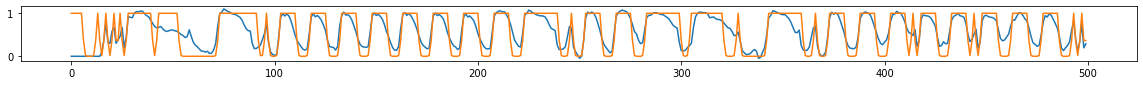

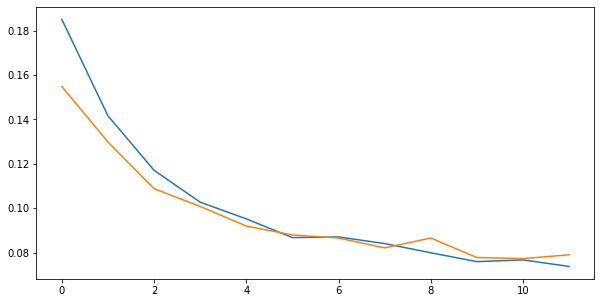

 Iters    Elapsed Time      Speed     loss                                      
 36/36  00:00:05<00:00:00  7.10it/s  0.0575                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

12 of 64
TRAIN LOSS: 0.07277204292929834
VAL LOSS: 0.07561548716492122
VAL_ACC05: 0.28706667661510726
VAL_ACC04: 0.30033244261908953


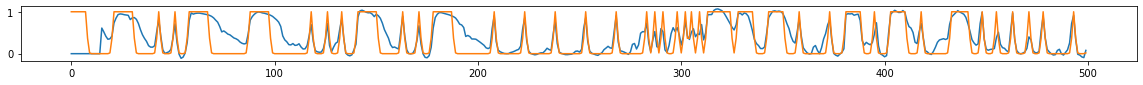

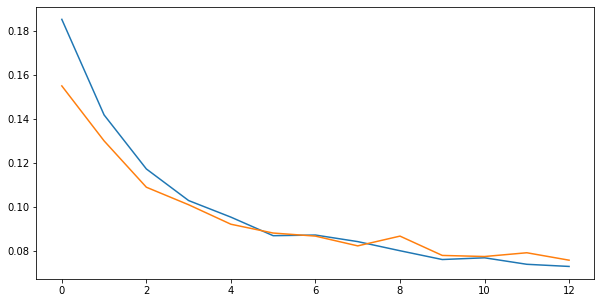

 Iters    Elapsed Time      Speed     loss                                      
 36/36  00:00:05<00:00:00  7.10it/s  0.0746                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

13 of 64
TRAIN LOSS: 0.07247814018693235
VAL LOSS: 0.07559305843379763
VAL_ACC05: 0.28595217905396453
VAL_ACC04: 0.2996334110552856


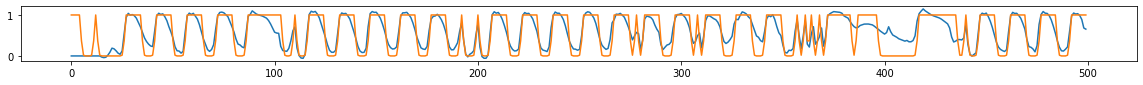

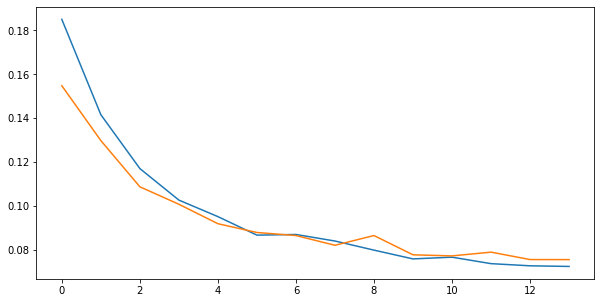

 Iters    Elapsed Time      Speed     loss                                      
 36/36  00:00:05<00:00:00  7.09it/s  0.0670                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

14 of 64
TRAIN LOSS: 0.06988845620718268
VAL LOSS: 0.07154590139786403
VAL_ACC05: 0.2794974810330917
VAL_ACC04: 0.2969179302440026


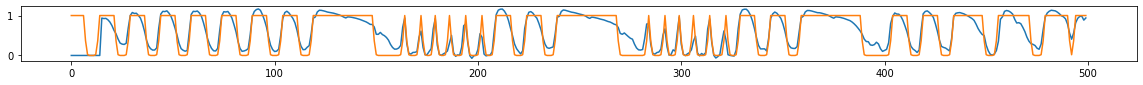

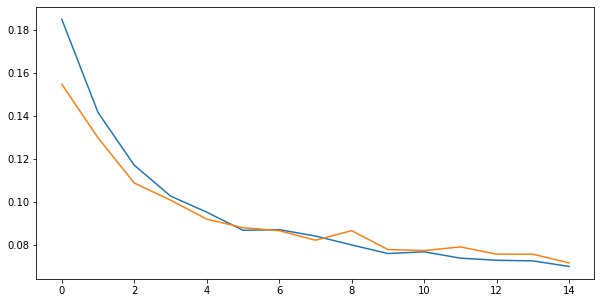

 Iters    Elapsed Time      Speed     loss                                      
 36/36  00:00:05<00:00:00  7.10it/s  0.0693                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

15 of 64
TRAIN LOSS: 0.06947277910593483
VAL LOSS: 0.0751180930270089
VAL_ACC05: 0.27664874060021916
VAL_ACC04: 0.29039543360513626


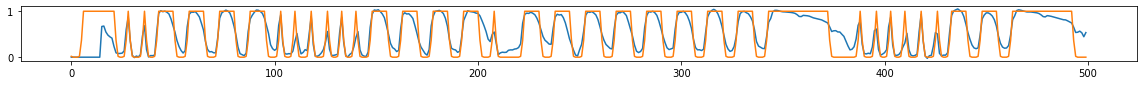

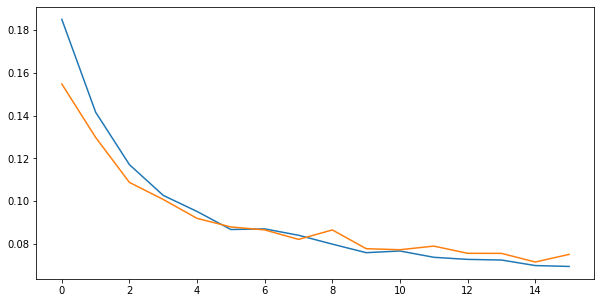

 Iters    Elapsed Time      Speed     loss                                      
 36/36  00:00:05<00:00:00  7.07it/s  0.0733                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

16 of 64
TRAIN LOSS: 0.06862536538392305
VAL LOSS: 0.06859312289290959
VAL_ACC05: 0.3025872012004732
VAL_ACC04: 0.31523035050912257


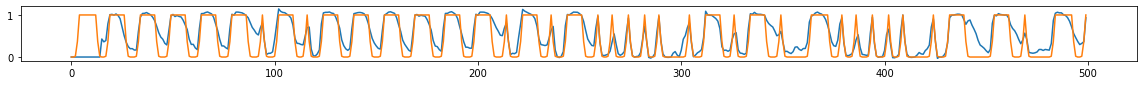

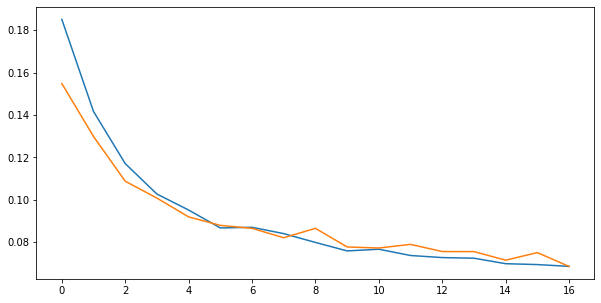

 Iters    Elapsed Time      Speed     loss                                      
 36/36  00:00:05<00:00:00  7.08it/s  0.0859                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

17 of 64
TRAIN LOSS: 0.06783678941428661
VAL LOSS: 0.07278189145856434
VAL_ACC05: 0.2911274083680276
VAL_ACC04: 0.30028917321780596


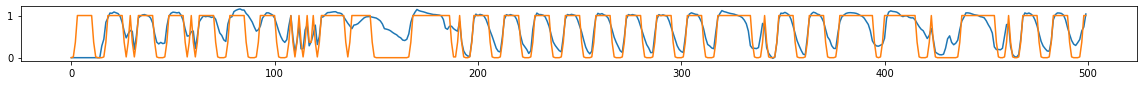

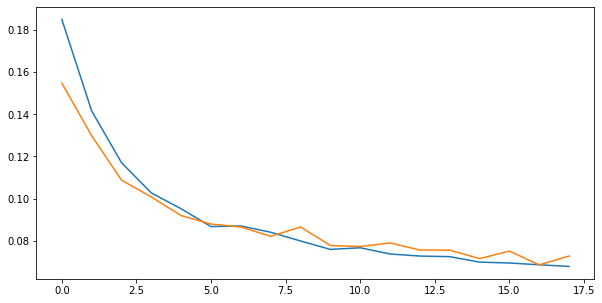

 Iters    Elapsed Time      Speed     loss                                      
 36/36  00:00:05<00:00:00  7.09it/s  0.0694                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

18 of 64
TRAIN LOSS: 0.06701082508597109
VAL LOSS: 0.07330496029721366
VAL_ACC05: 0.2832057454351131
VAL_ACC04: 0.2963691862450375


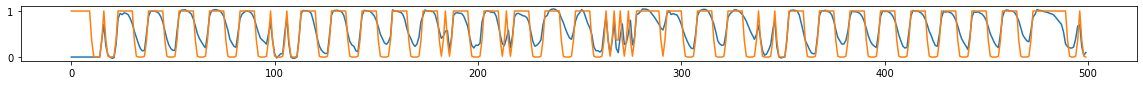

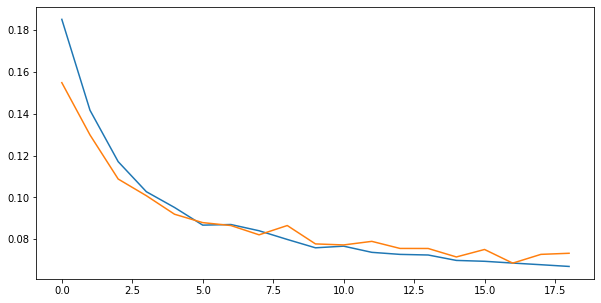

 Iters    Elapsed Time      Speed     loss                                      
 36/36  00:00:05<00:00:00  7.06it/s  0.0762                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

19 of 64
TRAIN LOSS: 0.06437837829192479
VAL LOSS: 0.07189568918612269
VAL_ACC05: 0.32079984547361534
VAL_ACC04: 0.32890821296091094


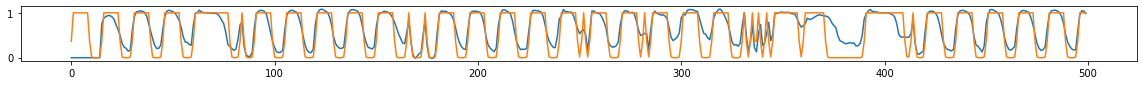

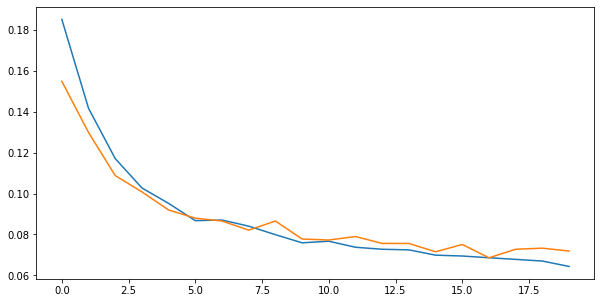

 Iters    Elapsed Time      Speed     loss                                      
 36/36  00:00:05<00:00:00  7.09it/s  0.0773                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

20 of 64
TRAIN LOSS: 0.06727631410790814
VAL LOSS: 0.07157202230559455
VAL_ACC05: 0.2834065028088665
VAL_ACC04: 0.295361592056149


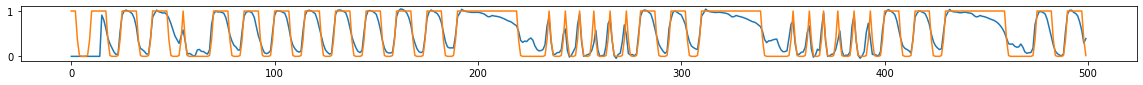

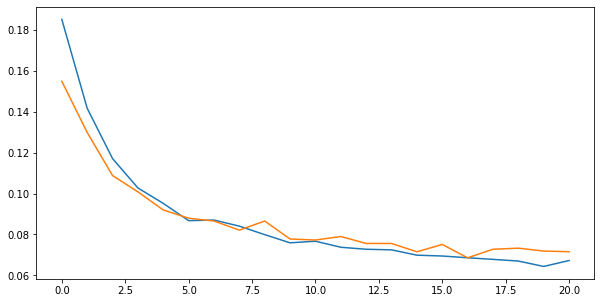

 Iters    Elapsed Time      Speed     loss                                      
 36/36  00:00:05<00:00:00  7.12it/s  0.0702                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

21 of 64
TRAIN LOSS: 0.06758067042877276
VAL LOSS: 0.0692378572291798
VAL_ACC05: 0.29637154749140876
VAL_ACC04: 0.3071270703902275


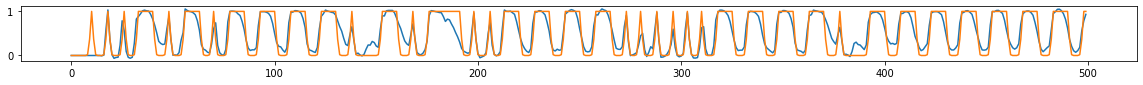

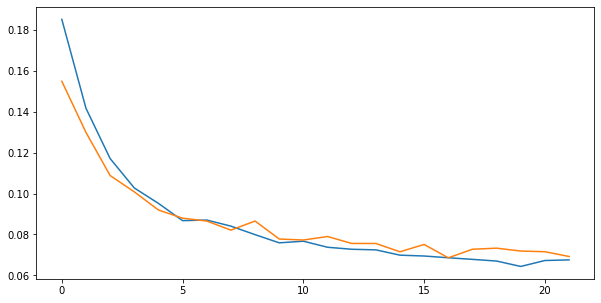

 Iters    Elapsed Time      Speed     loss                                      
 36/36  00:00:05<00:00:00  7.07it/s  0.0529                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

22 of 64
TRAIN LOSS: 0.06421034120851093
VAL LOSS: 0.0658093285229471
VAL_ACC05: 0.3189510611017099
VAL_ACC04: 0.3271247285076553


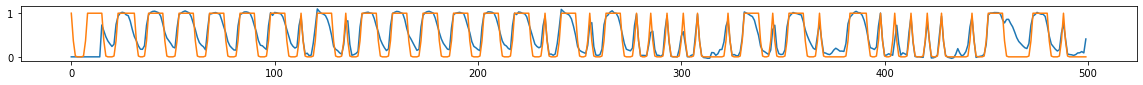

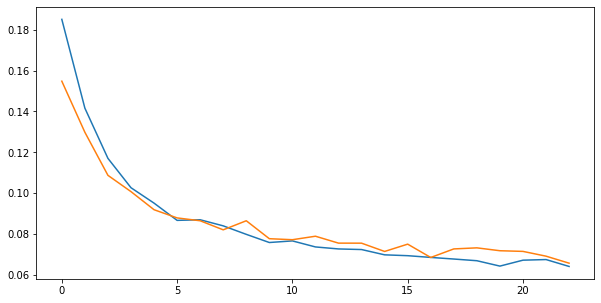

 Iters    Elapsed Time      Speed     loss                                      
 36/36  00:00:05<00:00:00  7.10it/s  0.0711                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

23 of 64
TRAIN LOSS: 0.06402958588053782
VAL LOSS: 0.06351068988442421
VAL_ACC05: 0.3104322027485086
VAL_ACC04: 0.3201235544045773


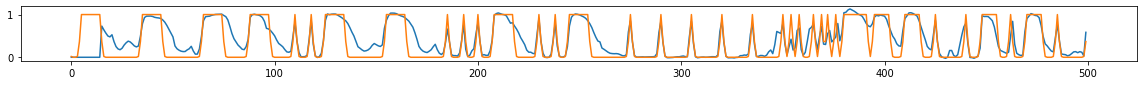

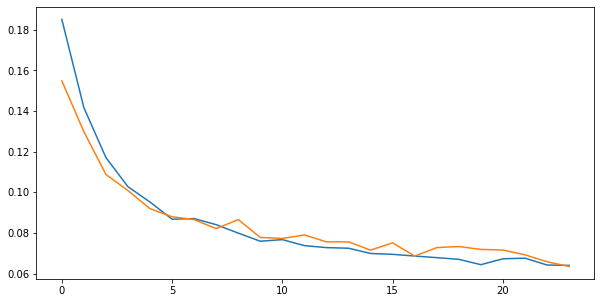

 Iters    Elapsed Time      Speed     loss                                      
 36/36  00:00:05<00:00:00  7.08it/s  0.0669                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

24 of 64
TRAIN LOSS: 0.06582176799161567
VAL LOSS: 0.0653088887532552
VAL_ACC05: 0.301378057379382
VAL_ACC04: 0.3137333146972413


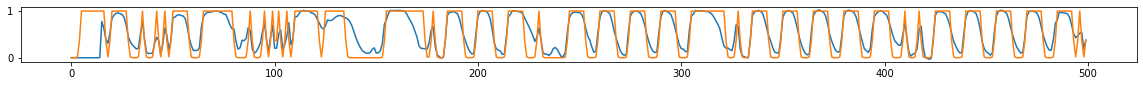

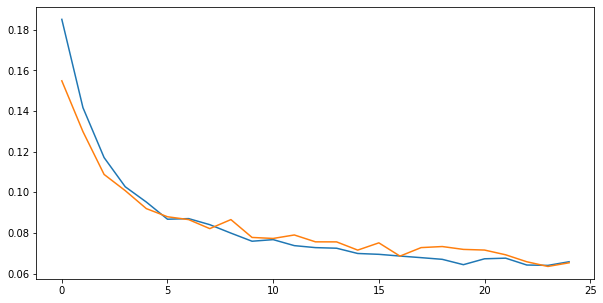

 Iters    Elapsed Time      Speed     loss                                      
 36/36  00:00:05<00:00:00  7.08it/s  0.0654                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

25 of 64
TRAIN LOSS: 0.06264237438639005
VAL LOSS: 0.06928549665543768
VAL_ACC05: 0.28689347582806213
VAL_ACC04: 0.2971534056356002


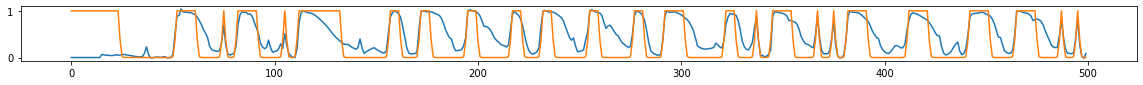

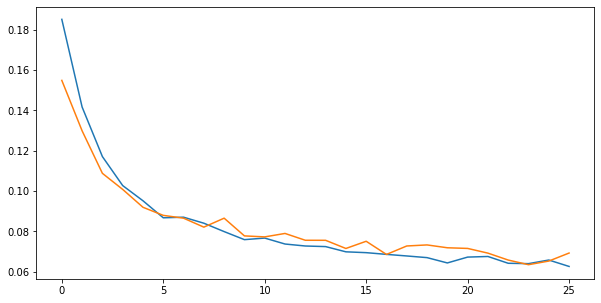

 Iters    Elapsed Time      Speed     loss                                      
 36/36  00:00:05<00:00:00  7.09it/s  0.0632                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

26 of 64
TRAIN LOSS: 0.062180259782407016
VAL LOSS: 0.06514704186055395
VAL_ACC05: 0.3033375174350501
VAL_ACC04: 0.31020144214891726


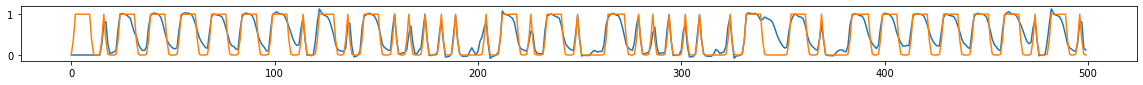

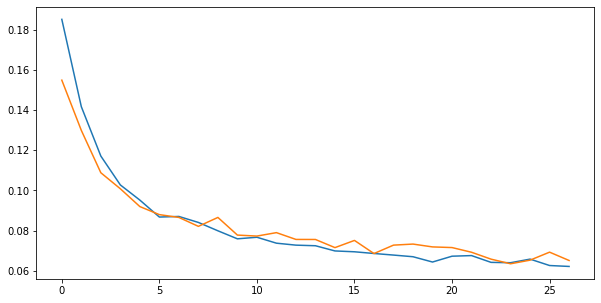

 Iters    Elapsed Time      Speed     loss                                      
 36/36  00:00:05<00:00:00  7.08it/s  0.0690                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

27 of 64
TRAIN LOSS: 0.06368232673654954
VAL LOSS: 0.061731392724646464
VAL_ACC05: 0.3149257619933408
VAL_ACC04: 0.32483454198920536


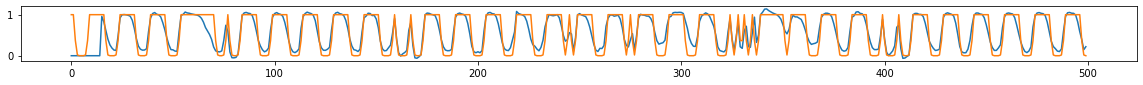

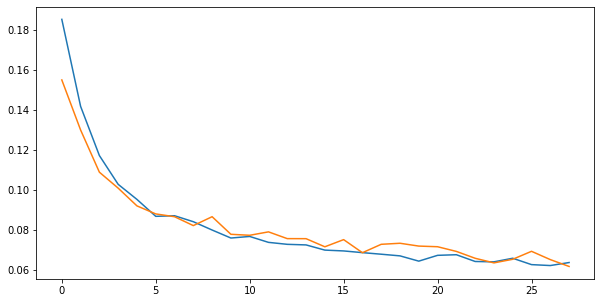

 Iters    Elapsed Time      Speed     loss                                      
 36/36  00:00:05<00:00:00  7.06it/s  0.0576                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

28 of 64
TRAIN LOSS: 0.05971728379113807
VAL LOSS: 0.06212399237685733
VAL_ACC05: 0.2881609076867834
VAL_ACC04: 0.2979923997444565


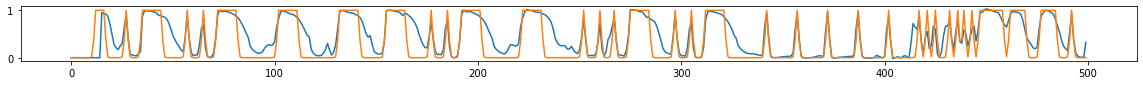

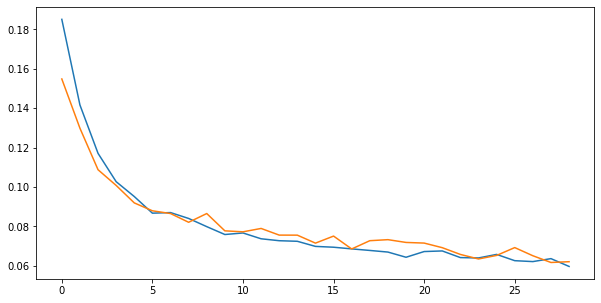

 Iters    Elapsed Time      Speed     loss                                      
 36/36  00:00:05<00:00:00  7.08it/s  0.0562                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

29 of 64
TRAIN LOSS: 0.06178634292963478
VAL LOSS: 0.06411907159619862
VAL_ACC05: 0.30841644030271287
VAL_ACC04: 0.31764197362674085


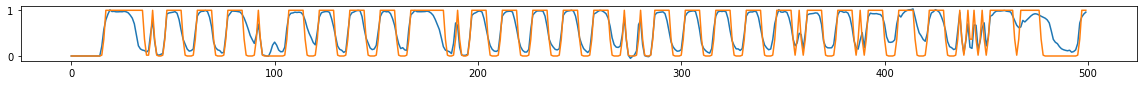

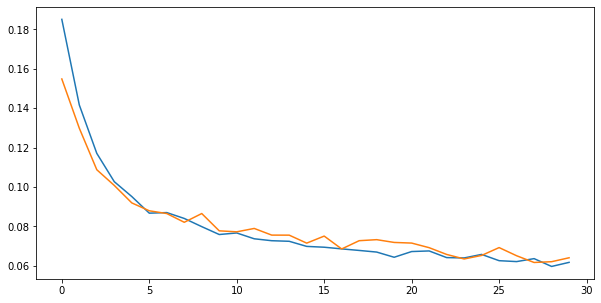

 Iters    Elapsed Time      Speed     loss                                      
 36/36  00:00:05<00:00:00  7.07it/s  0.0459                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

30 of 64
TRAIN LOSS: 0.06033105713625749
VAL LOSS: 0.06656912838419278
VAL_ACC05: 0.3057855157513403
VAL_ACC04: 0.3121265587634049


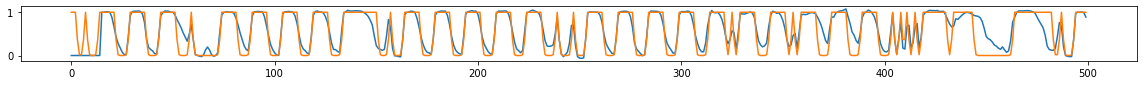

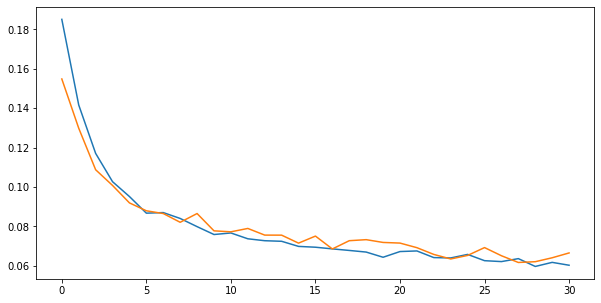

 Iters    Elapsed Time      Speed     loss                                      
 36/36  00:00:05<00:00:00  7.10it/s  0.0646                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

31 of 64
TRAIN LOSS: 0.058303301533063255
VAL LOSS: 0.06287321324149768
VAL_ACC05: 0.3178050182768782
VAL_ACC04: 0.3259144782551572


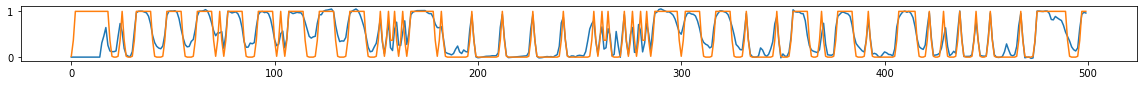

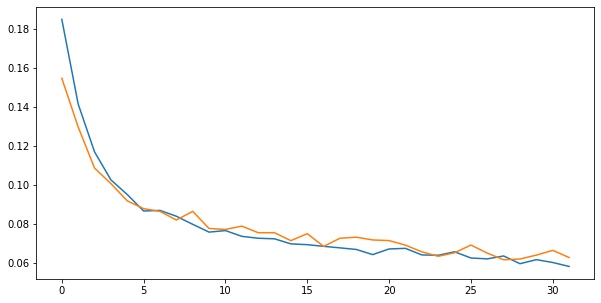

 Iters    Elapsed Time      Speed     loss                                      
 36/36  00:00:05<00:00:00  7.09it/s  0.0607                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

32 of 64
TRAIN LOSS: 0.06006235618972116
VAL LOSS: 0.059934891760349274
VAL_ACC05: 0.3025136425334974
VAL_ACC04: 0.31166634690397504


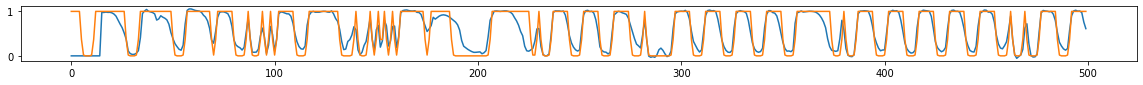

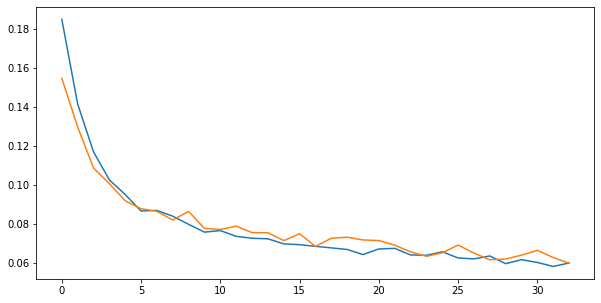

 Iters    Elapsed Time      Speed     loss                                      
 36/36  00:00:05<00:00:00  7.08it/s  0.0541                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

33 of 64
TRAIN LOSS: 0.05794564986394511
VAL LOSS: 0.06651053287916714
VAL_ACC05: 0.29357323693489057
VAL_ACC04: 0.3015242927905955


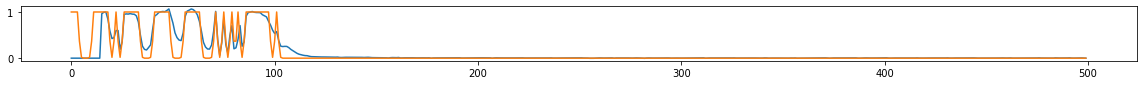

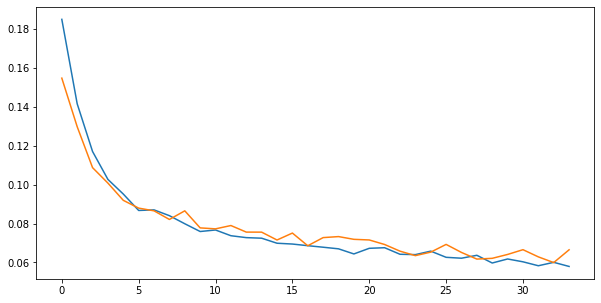

 Iters    Elapsed Time      Speed     loss                                      
 36/36  00:00:05<00:00:00  7.09it/s  0.0692                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

34 of 64
TRAIN LOSS: 0.061495600992606744
VAL LOSS: 0.058572248038318425
VAL_ACC05: 0.3114399350235131
VAL_ACC04: 0.3197310179328729


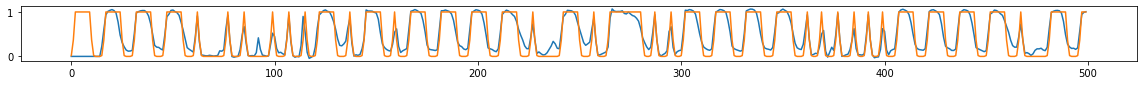

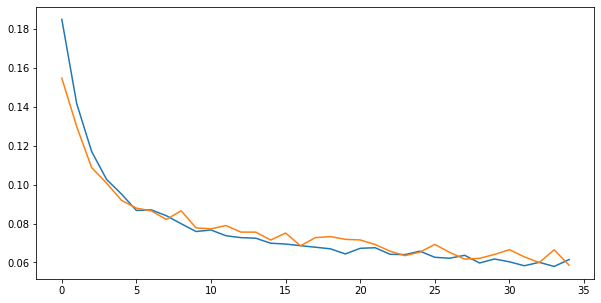

 Iters    Elapsed Time      Speed     loss                                      
 36/36  00:00:05<00:00:00  7.07it/s  0.0629                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

35 of 64
TRAIN LOSS: 0.05841177277680901
VAL LOSS: 0.06092918001943164
VAL_ACC05: 0.31022452198385847
VAL_ACC04: 0.3157640465588739


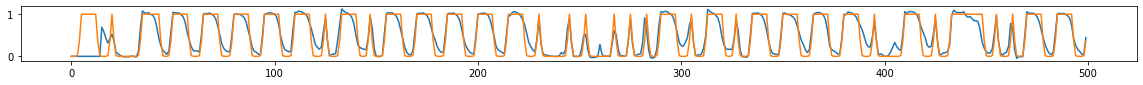

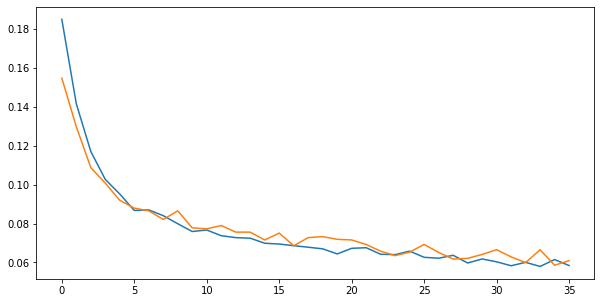

 Iters    Elapsed Time      Speed     loss                                      
 36/36  00:00:05<00:00:00  7.07it/s  0.0712                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

36 of 64
TRAIN LOSS: 0.0595988625039657
VAL LOSS: 0.06311091366741392
VAL_ACC05: 0.3250624839220271
VAL_ACC04: 0.33199318556618096


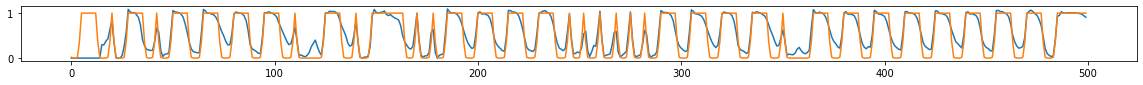

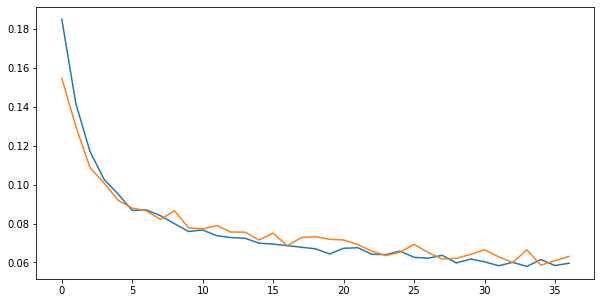

 Iters    Elapsed Time      Speed     loss                                      
 36/36  00:00:05<00:00:00  7.10it/s  0.0637                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

37 of 64
TRAIN LOSS: 0.0577022194241484
VAL LOSS: 0.06369680083460277
VAL_ACC05: 0.3041335472341331
VAL_ACC04: 0.3104821650583289


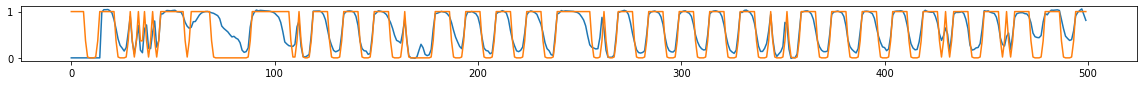

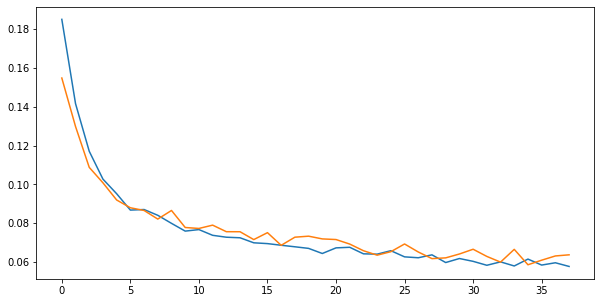

 Iters    Elapsed Time      Speed     loss                                      
 36/36  00:00:05<00:00:00  7.05it/s  0.0608                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

38 of 64
TRAIN LOSS: 0.05861826416932874
VAL LOSS: 0.06367038190364838
VAL_ACC05: 0.3142516208783153
VAL_ACC04: 0.32441379399991255


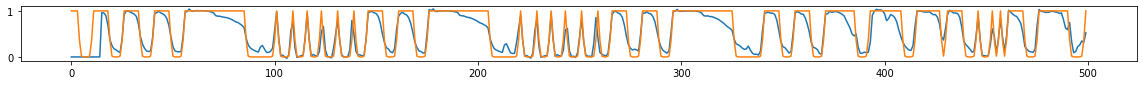

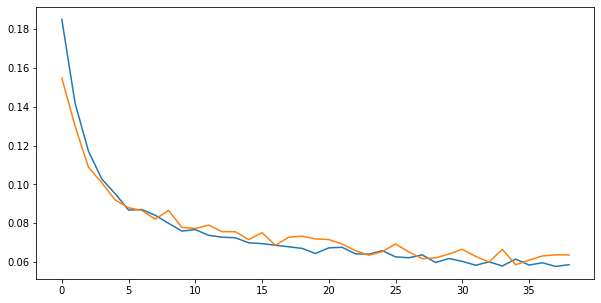

 Iters    Elapsed Time      Speed     loss                                      
 36/36  00:00:05<00:00:00  7.10it/s  0.0682                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

39 of 64
TRAIN LOSS: 0.05791911265502373
VAL LOSS: 0.06550508737564087
VAL_ACC05: 0.28457871877021446
VAL_ACC04: 0.2926227257506972


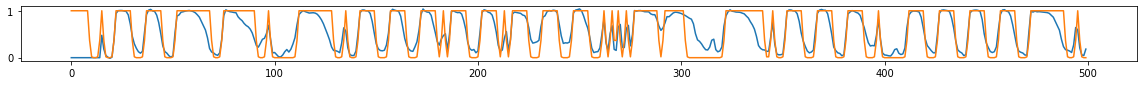

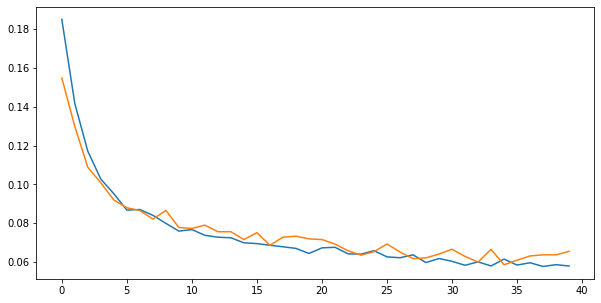

 Iters    Elapsed Time      Speed     loss                                      
 36/36  00:00:05<00:00:00  7.08it/s  0.0509                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

40 of 64
TRAIN LOSS: 0.05947273038327694
VAL LOSS: 0.06460325171550114
VAL_ACC05: 0.28306786904901976
VAL_ACC04: 0.290461636193913


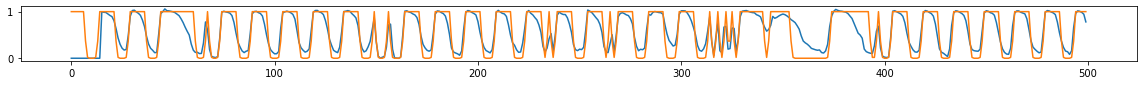

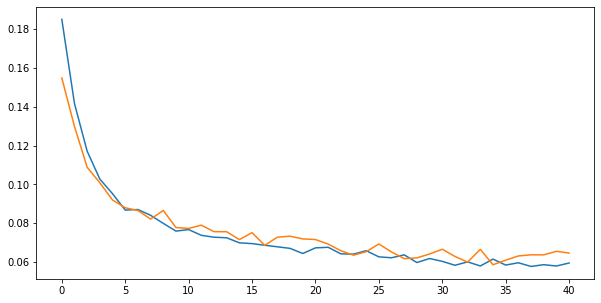

 Iters    Elapsed Time      Speed     loss                                      
 36/36  00:00:05<00:00:00  7.11it/s  0.0493                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

41 of 64
TRAIN LOSS: 0.05714810142914454
VAL LOSS: 0.06099837687280443
VAL_ACC05: 0.3103951001794211
VAL_ACC04: 0.3162940795611124


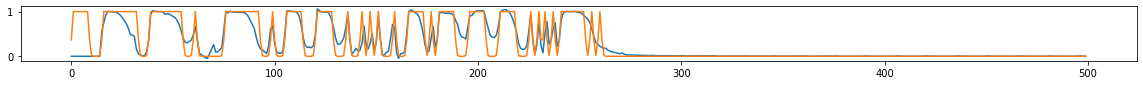

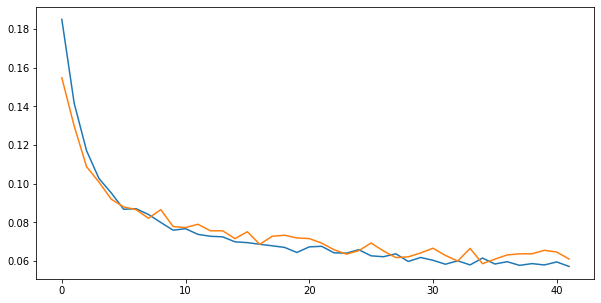

 Iters    Elapsed Time      Speed     loss                                      
 36/36  00:00:05<00:00:00  7.07it/s  0.0635                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

42 of 64
TRAIN LOSS: 0.057425080281164914
VAL LOSS: 0.05910658256875144
VAL_ACC05: 0.32075060481366263
VAL_ACC04: 0.3261861677710577


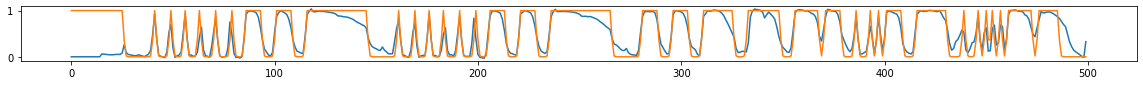

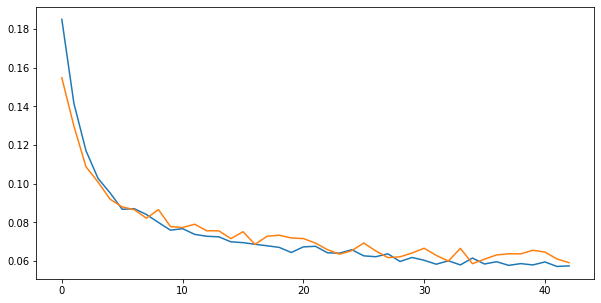

 Iters    Elapsed Time      Speed     loss                                      
 36/36  00:00:05<00:00:00  7.08it/s  0.0617                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

43 of 64
TRAIN LOSS: 0.055838021656705275
VAL LOSS: 0.06262225699093607
VAL_ACC05: 0.3121898271609817
VAL_ACC04: 0.3186023960353819


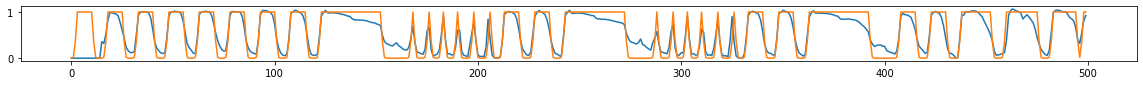

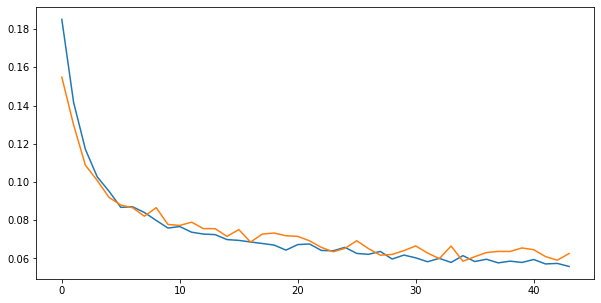

 Iters    Elapsed Time      Speed     loss                                      
 36/36  00:00:05<00:00:00  7.07it/s  0.0555                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

44 of 64
TRAIN LOSS: 0.05681900824937555
VAL LOSS: 0.05735935933060116
VAL_ACC05: 0.3272740534292957
VAL_ACC04: 0.33464210911703846


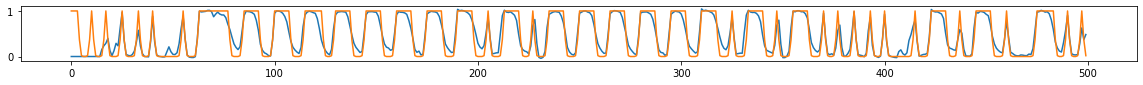

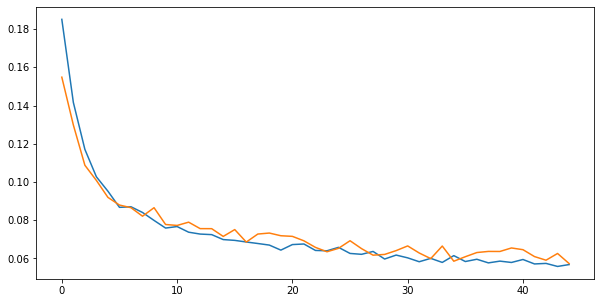

 Iters    Elapsed Time      Speed     loss                                      
 36/36  00:00:05<00:00:00  7.08it/s  0.0703                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

45 of 64
TRAIN LOSS: 0.057176989089283675
VAL LOSS: 0.060334396445088916
VAL_ACC05: 0.3270499104818415
VAL_ACC04: 0.332696809977308


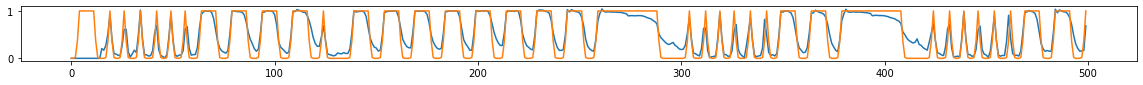

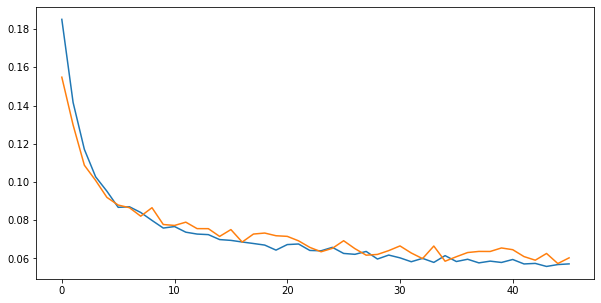

 Iters    Elapsed Time      Speed     loss                                      
 36/36  00:00:05<00:00:00  7.09it/s  0.0460                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

46 of 64
TRAIN LOSS: 0.05538924183282587
VAL LOSS: 0.06032155950864156
VAL_ACC05: 0.3019656122542631
VAL_ACC04: 0.3099447203933857


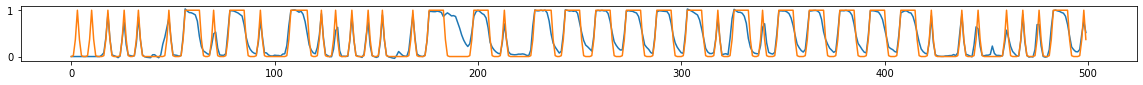

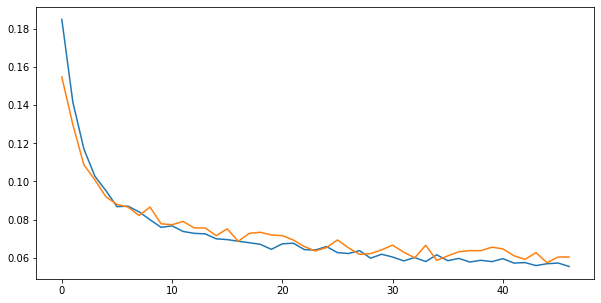

 Iters    Elapsed Time      Speed     loss                                      
 36/36  00:00:05<00:00:00  7.09it/s  0.0506                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

47 of 64
TRAIN LOSS: 0.054836512750221625
VAL LOSS: 0.05828814994957712
VAL_ACC05: 0.3423818666197503
VAL_ACC04: 0.34750352274312407


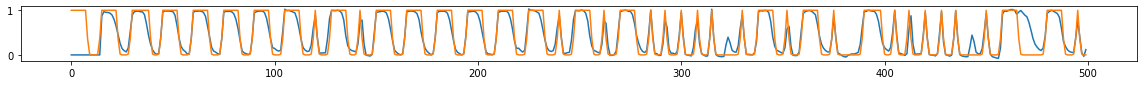

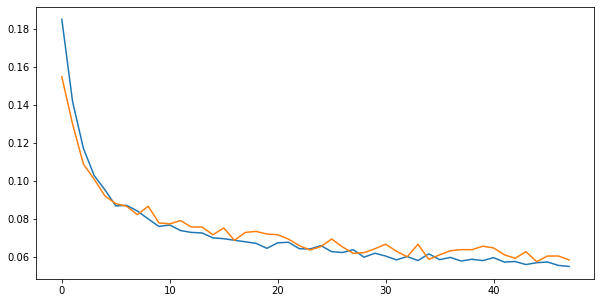

 Iters    Elapsed Time      Speed     loss                                      
 36/36  00:00:05<00:00:00  7.06it/s  0.0617                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

48 of 64
TRAIN LOSS: 0.0564223053968615
VAL LOSS: 0.05961338430643082
VAL_ACC05: 0.3281631691137241
VAL_ACC04: 0.33326789066994444


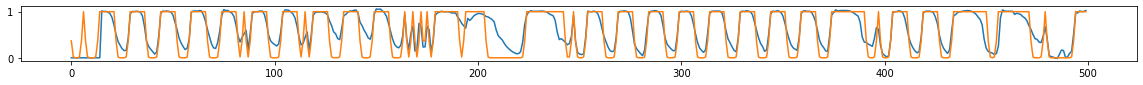

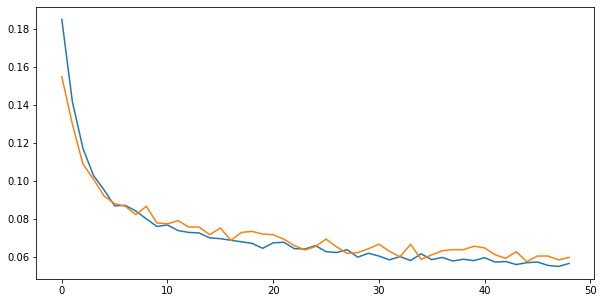

 Iters    Elapsed Time      Speed     loss                                      
 36/36  00:00:05<00:00:00  7.09it/s  0.0433                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

49 of 64
TRAIN LOSS: 0.05539639925377236
VAL LOSS: 0.06198739384611448
VAL_ACC05: 0.3099098228889521
VAL_ACC04: 0.31761090642578543


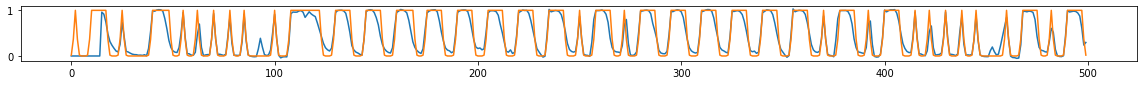

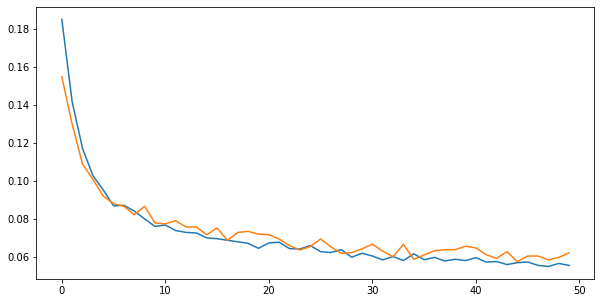

 Iters    Elapsed Time      Speed     loss                                      
 36/36  00:00:05<00:00:00  7.08it/s  0.0520                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

50 of 64
TRAIN LOSS: 0.05557858395493693
VAL LOSS: 0.060918471051587
VAL_ACC05: 0.32369287960687915
VAL_ACC04: 0.3291020496371105


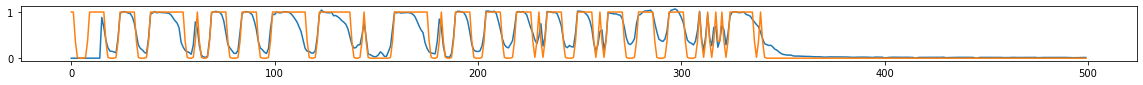

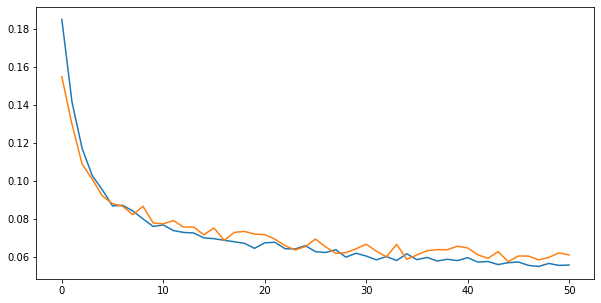

 Iters    Elapsed Time      Speed     loss                                      
 36/36  00:00:05<00:00:00  7.08it/s  0.0610                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

51 of 64
TRAIN LOSS: 0.06541760441743666
VAL LOSS: 0.07767719030380249
VAL_ACC05: 0.30784260118737294
VAL_ACC04: 0.31641968634759393


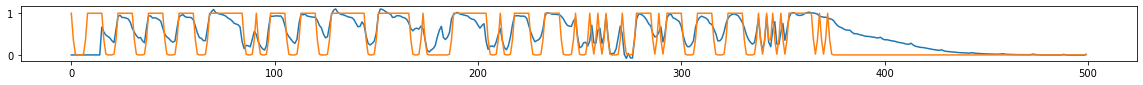

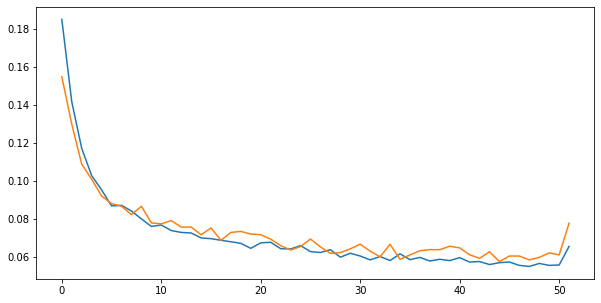

 Iters    Elapsed Time      Speed     loss                                      
 36/36  00:00:05<00:00:00  7.08it/s  0.0590                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

52 of 64
TRAIN LOSS: 0.06811660538531011
VAL LOSS: 0.06608142414026791
VAL_ACC05: 0.2943100536681252
VAL_ACC04: 0.3016675298914917


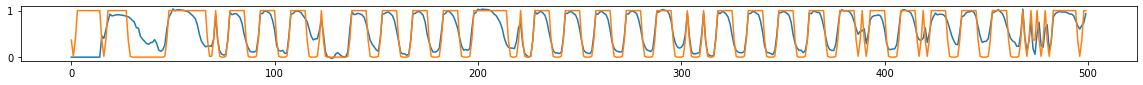

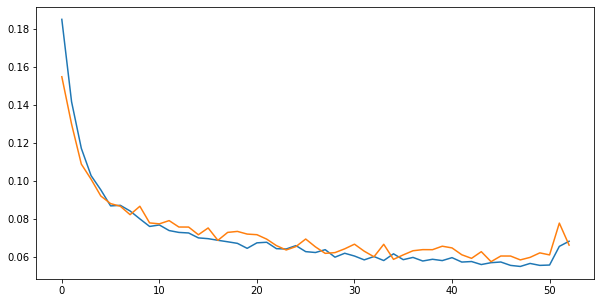

 Iters    Elapsed Time      Speed     loss                                      
 36/36  00:00:05<00:00:00  7.10it/s  0.0726                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

53 of 64
TRAIN LOSS: 0.061020724992785186
VAL LOSS: 0.06481264779965083
VAL_ACC05: 0.3006326659353195
VAL_ACC04: 0.30761535706998555


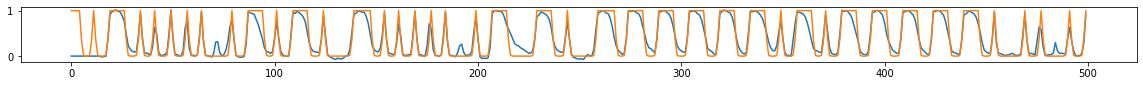

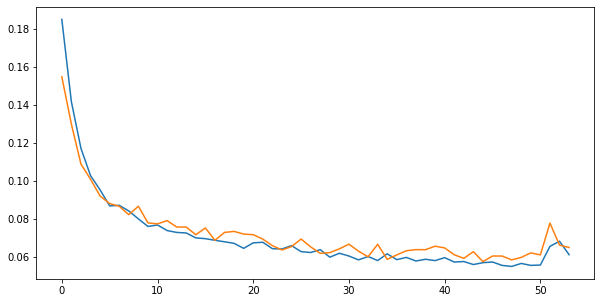

 Iters    Elapsed Time      Speed     loss                                      
 36/36  00:00:05<00:00:00  7.08it/s  0.0603                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

54 of 64
TRAIN LOSS: 0.059712041893766984
VAL LOSS: 0.062085847887727946
VAL_ACC05: 0.32017762910248165
VAL_ACC04: 0.3257640855385031


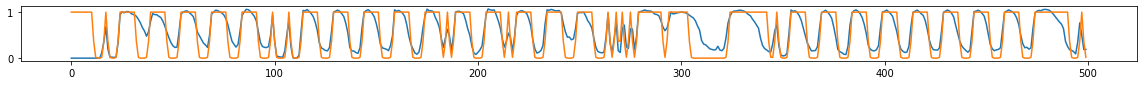

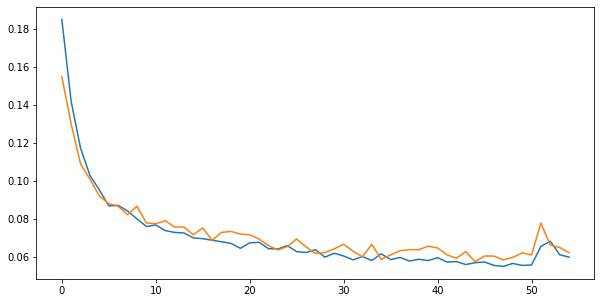

 Iters    Elapsed Time      Speed     loss                                      
 36/36  00:00:05<00:00:00  7.10it/s  0.0791                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

55 of 64
TRAIN LOSS: 0.057361605991091996
VAL LOSS: 0.0626069311466482
VAL_ACC05: 0.34155697905545046
VAL_ACC04: 0.34757020773174085


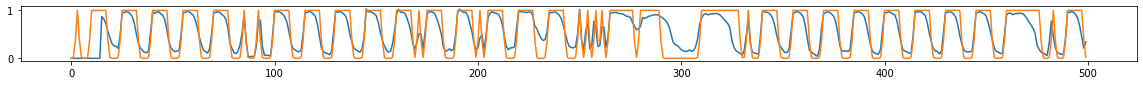

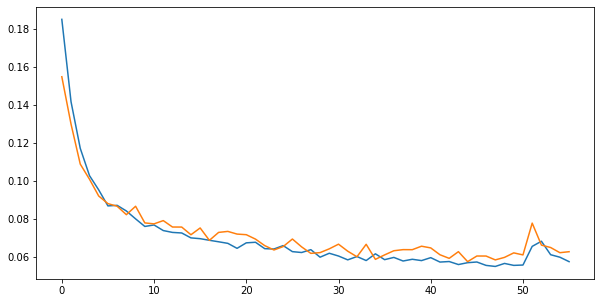

 Iters    Elapsed Time      Speed     loss                                      
 36/36  00:00:05<00:00:00  7.10it/s  0.0528                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

56 of 64
TRAIN LOSS: 0.05682565540903144
VAL LOSS: 0.059123931659592524
VAL_ACC05: 0.3279272430394372
VAL_ACC04: 0.3329670388805356


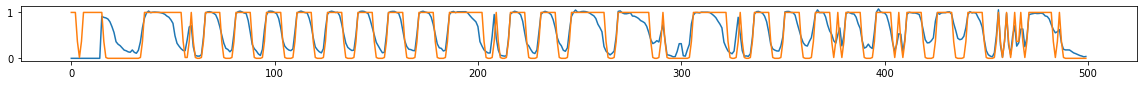

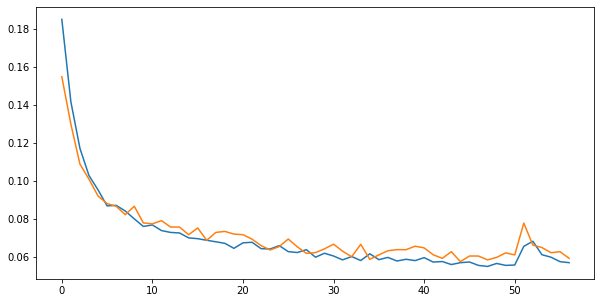

 Iters    Elapsed Time      Speed     loss                                      
 36/36  00:00:05<00:00:00  7.07it/s  0.0641                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

57 of 64
TRAIN LOSS: 0.05593641630063454
VAL LOSS: 0.06292272607485454
VAL_ACC05: 0.2955825893193229
VAL_ACC04: 0.305124357375822


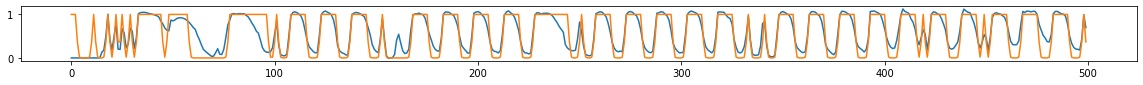

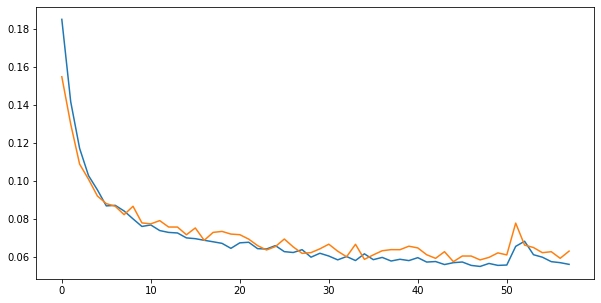

 Iters    Elapsed Time      Speed     loss                                      
 36/36  00:00:05<00:00:00  7.10it/s  0.0502                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

58 of 64
TRAIN LOSS: 0.055794678214523524
VAL LOSS: 0.05912904524140888
VAL_ACC05: 0.3198880735938605
VAL_ACC04: 0.32553785512094635


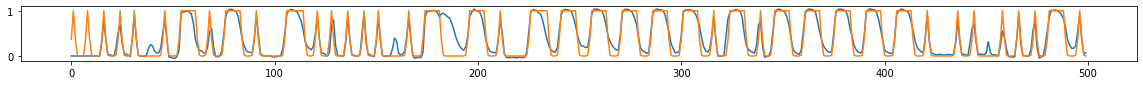

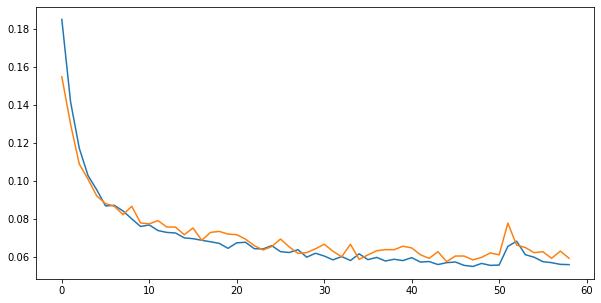

 Iters    Elapsed Time      Speed     loss                                      
 36/36  00:00:05<00:00:00  7.07it/s  0.0425                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

59 of 64
TRAIN LOSS: 0.055824661110010415
VAL LOSS: 0.0610233528746499
VAL_ACC05: 0.3232388036394671
VAL_ACC04: 0.3283768061505941


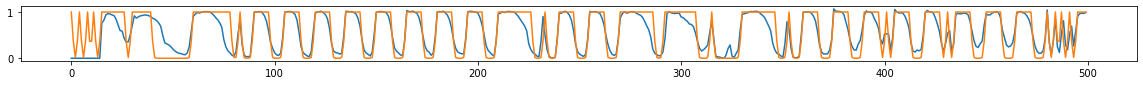

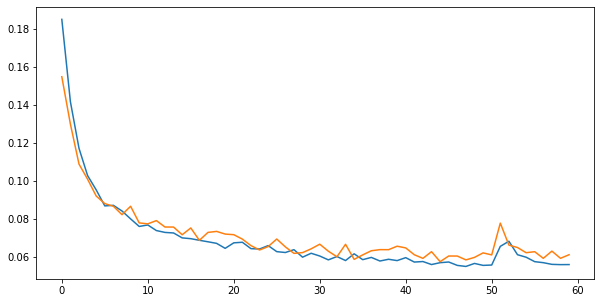

 Iters    Elapsed Time      Speed     loss                                      
 36/36  00:00:05<00:00:00  7.07it/s  0.0648                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

60 of 64
TRAIN LOSS: 0.05785458959225151
VAL LOSS: 0.06425190716981888
VAL_ACC05: 0.31948099348841363
VAL_ACC04: 0.32556039448893426


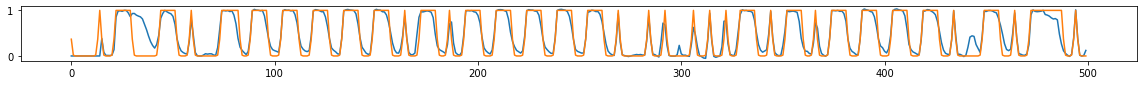

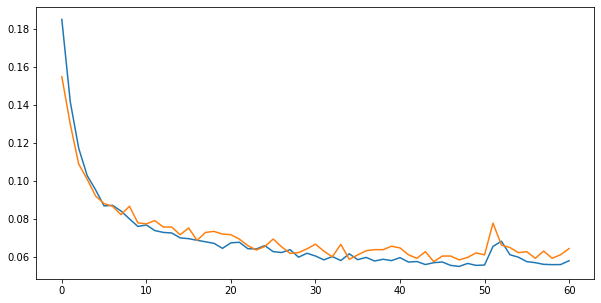

 Iters    Elapsed Time      Speed     loss                                      
 36/36  00:00:05<00:00:00  7.11it/s  0.0622                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

61 of 64
TRAIN LOSS: 0.056457644121514425
VAL LOSS: 0.0580981680088573
VAL_ACC05: 0.31851532817048683
VAL_ACC04: 0.3260600335501036


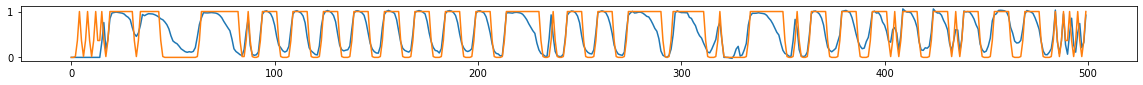

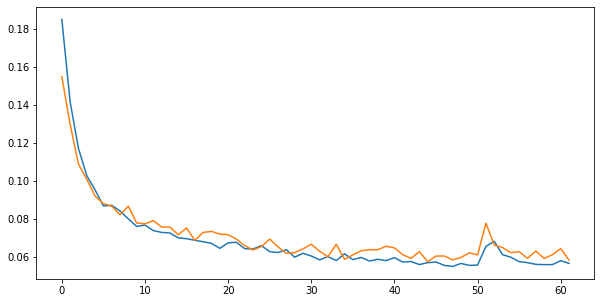

 Iters    Elapsed Time      Speed     loss                                      
 36/36  00:00:05<00:00:00  7.09it/s  0.0509                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

62 of 64
TRAIN LOSS: 0.055176489469077855
VAL LOSS: 0.056638573192887835
VAL_ACC05: 0.33710675448288596
VAL_ACC04: 0.3425519812122554


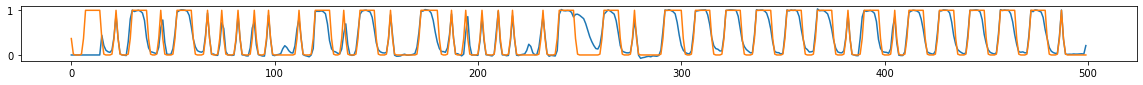

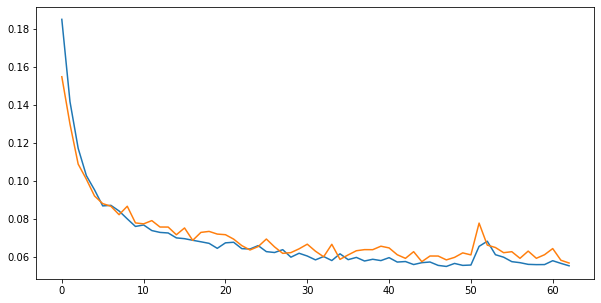

 Iters    Elapsed Time      Speed     loss                                      
 36/36  00:00:05<00:00:00  7.05it/s  0.0484                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

63 of 64
TRAIN LOSS: 0.05365027476929956
VAL LOSS: 0.058637635989321604
VAL_ACC05: 0.3067109016723764
VAL_ACC04: 0.31110310449838974


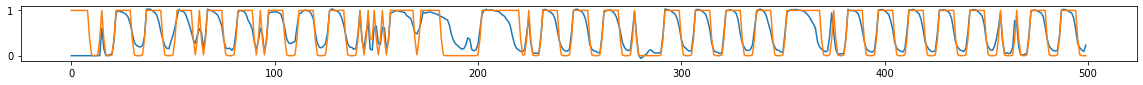

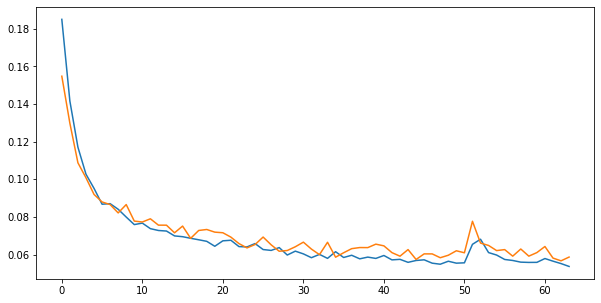

495.69410467147827 secs


In [55]:
start = time.time()

epochs = 64
train()

end = time.time()
print(end - start, 'secs')

In [56]:
torch.save(model.state_dict(), model_path + str(epoch_cum) + '.pt')

In [ ]:
train_hist = train_hist[10:]
val_hist = val_hist[10:]

In [ ]:
start = time.time()

epochs = 64
train()

end = time.time()
print(end - start, 'secs')

In [ ]:
torch.save(model.state_dict(), model_path + str(epoch_cum) + '.pt')

# Test model

In [26]:
import torch

In [27]:
model.load_state_dict(torch.load('models/HN/model07_gaussian64.pt'))

<All keys matched successfully>

In [28]:
osud = '../ex/beatmaps/567301 LamazeP - Spam Jack'
osuf = 'LamazeP - Spam Jack (OsuToothbrush) [SPAM].osu'
#osud = '../ex/beatmaps/252981 DJ Okawari - Flower Dance (Short Ver)'
#osuf = 'DJ Okawari - Flower Dance (Short Ver.) (-Hanayuki-) [Relax].osu'
#osud = '../ex/beatmaps/348381 sasakureUK - Spider Thread Monopoly feat Hatsune Miku'
#osuf = 'sasakure.UK - Spider Thread Monopoly feat. Hatsune Miku (Mishima Yurara) [Milan-\'s Hard].osu'

In [29]:
log_spect = LOG_SPECT(sample_rate=sample_rate, hop_size=hop_size, n_bands=[24], mode='offline')
osubeatmap = Beatmap(osud, osuf, log_spect, sample_rate=sample_rate, hop_size=hop_size, width=width, peak_type=peak_type, tmp='./wav/')

In [30]:
a, b, o = osubeatmap.get_audio(), osubeatmap.get_beats(), osubeatmap.get_hitobjects()
h = osubeatmap.get_hits()
A, B, O = a.to(device).unsqueeze(0), b.to(device).unsqueeze(0), o.to(device).unsqueeze(0)

In [31]:
model.to(device)
model.init_hidden(1)
model.eval()
P = model(A, B, O)

In [32]:
p = P.cpu().detach().numpy().squeeze(0)
#acc = hit_precentage(p, h, 0.4)

#print(acc)

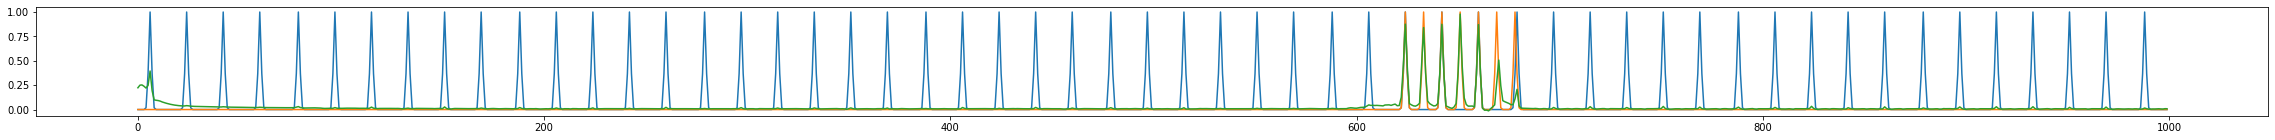

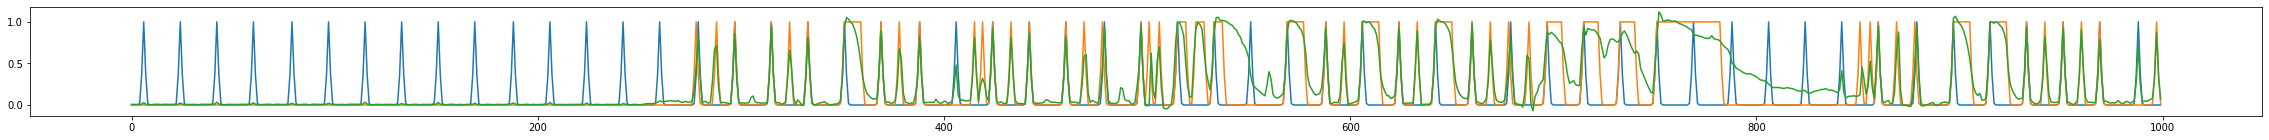

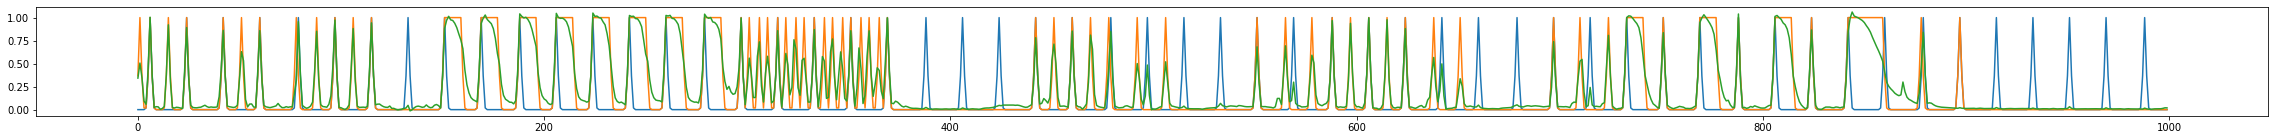

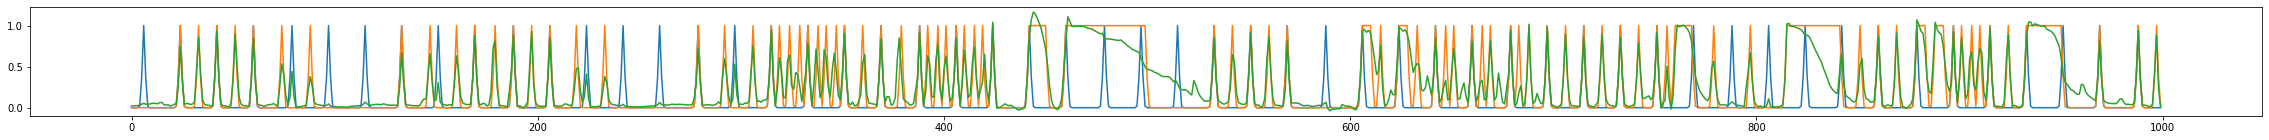

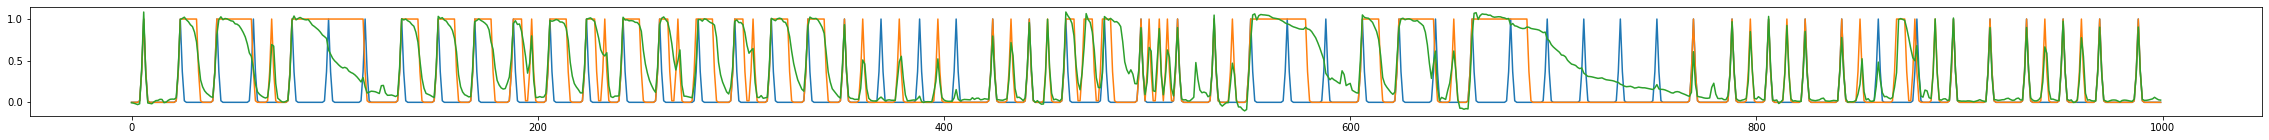

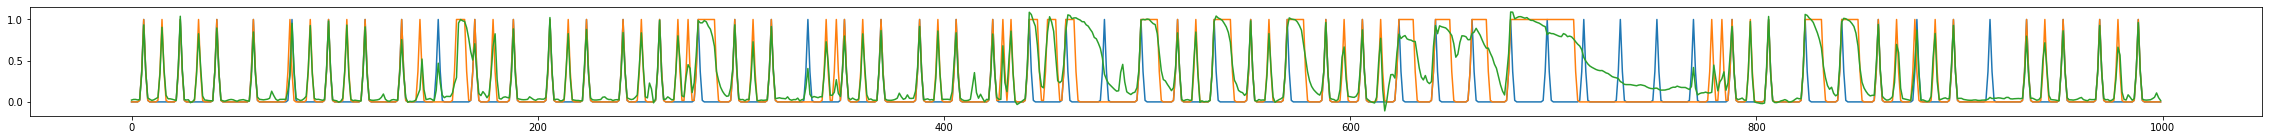

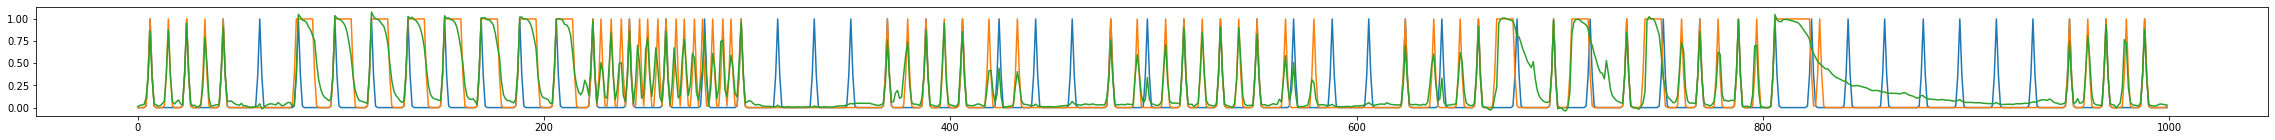

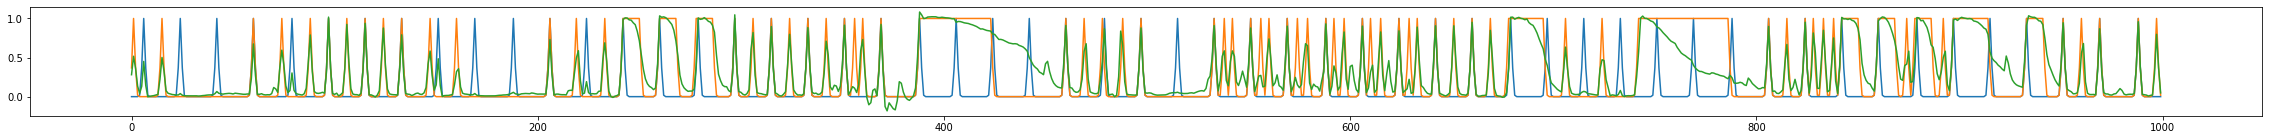

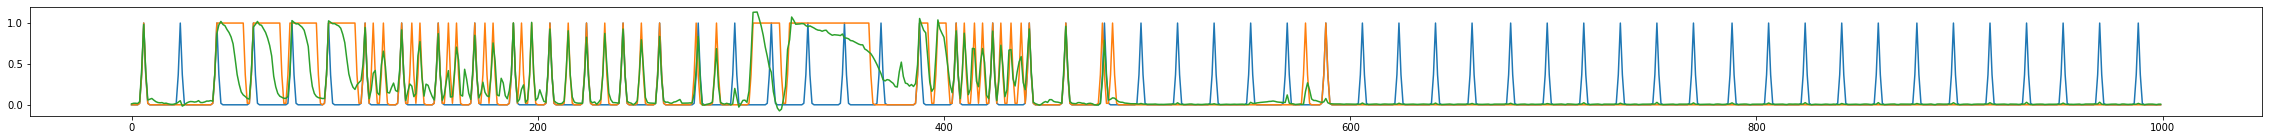

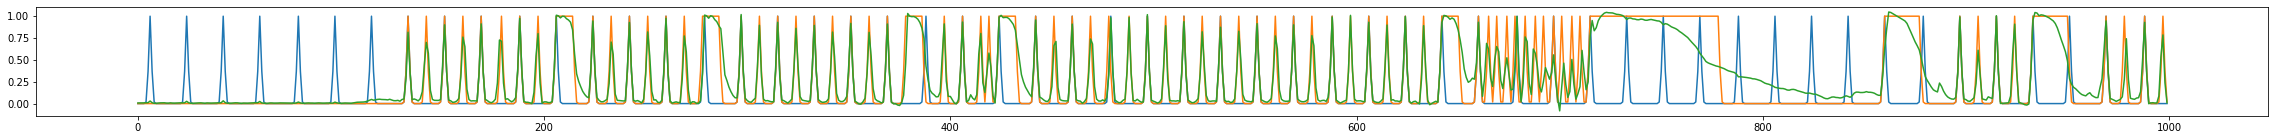

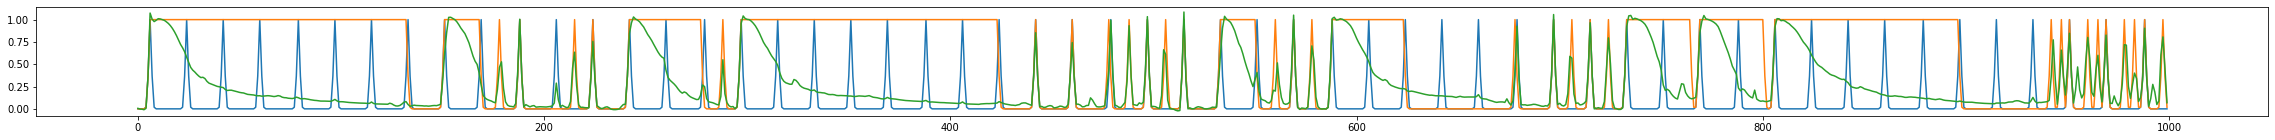

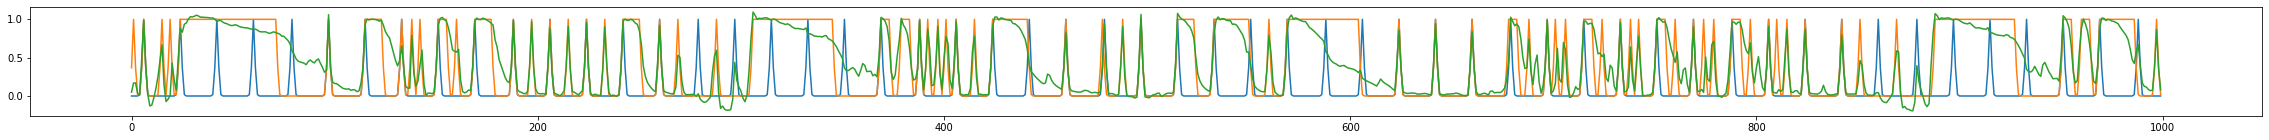

In [33]:
plt.rcParams["figure.figsize"] = (40,2)
for i in range(int(len(p)/1000) - 1):
    plt.plot(b[1000*i:1000*(i+1)])
    plt.plot(h[1000*i:1000*(i+1)])
    plt.plot(p[1000*i:1000*(i+1)])
    plt.show()

# Create Replay Video

In [34]:
from IPython.display import Video

In [35]:
np.save('predHN.npy', p)

In [36]:
eosud = osud.replace('/', '\/')

In [37]:
!sed -i "s/Beatmap path.*/Beatmap path\": \"$eosud\/$osuf\",/" data.json
!sed -i "s/Output path.*/Output path\": \"videoHN.mp4\",/" data.json

In [38]:
!python create_replayHN.py predHN.npy 50 0.5

2022-04-13 04:17:20,389:INFO:osr2mp4.Osr2mp4:__init__:test
2022-04-13 04:17:20,390:TRACE:osr2mp4.Utils.Setup:setupglobals:CALL *({'osu! path': '', 'Skin path': 'skin/', 'Beatmap path': '../ex/beatmaps/567301 LamazeP - Spam Jack/LamazeP - Spam Jack (OsuToothbrush) [SPAM].osu', '.osr path': 'auto', 'Default skin path': 'skin/', 'Output path': 'videoHN.mp4', 'Width': 1024, 'Height': 600, 'FPS': 30, 'Start time': 0, 'End time': -1, 'Video codec': 'mjpeg', 'Process': 0, 'ffmpeg path': 'ffmpeg'}, {'Show score meter': True, 'Always show key overlay': True, 'Song volume': 100, 'Effect volume': 100, 'Enable PP counter': True, 'Enable Strain Graph': True, 'FFmpeg codec': 'libx264', 'FFmpeg custom commands': '', 'Audio bitrate': 320, 'api key': None, 'Use FFmpeg video writer': True, 'Custom mods': ''}, [], <osr2mp4.global_var.Settings object at 0x7fd53aae4430>) **{'ppsettings': {'x': 1220, 'y': 690, 'text_x': 1140, 'text_y': 748, 'Font Size': 20, 'Size': 10, 'Rgb': [200, 214, 229], 'Alpha': 0.9, 

In [39]:
Video("videoHN.mp4")